In [1]:
import warnings
import os
import sys

# --- 1. Standard Python Warnings ---
# Filter out common warning categories explicitly
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Specific Library Warnings (e.g., Scikit-learn) ---
# Suppress warnings from scikit-learn's specific modules if they are particularly noisy
try:
    from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    # You can also target specific module paths if a warning originates there
    # warnings.filterwarnings('ignore', module='sklearn.linear_model._logistic')
except ImportError:
    pass # sklearn might not be imported yet, or not installed

# --- 3. For Parallel Processing (n_jobs > 1 or n_jobs = -1) ---
# This is often the culprit for persistent warnings, especially with sklearn.
# It sets an environment variable that child processes might inherit.
os.environ["PYTHONWARNINGS"] = "ignore"

# --- 4. Advanced/Less Common Suppression (if still seeing issues) ---
# Sometimes, warnings might be generated very early during interpreter startup
# or by low-level C extensions. This can catch some of those.
if not sys.warnoptions:
    warnings.simplefilter("ignore")

print("All common warnings suppressed for this notebook session.")

All common warnings suppressed for this notebook session.


# CICIDS2017 ML Pipeline for Multi-Class Classification

# Business Goal

The primary business goal of this project is to significantly enhance the organization's cybersecurity defense capabilities by enabling highly accurate and granular real-time identification of diverse network attack types, thereby minimizing potential damage, reducing response times, and optimizing security resource allocation.

### Key Objectives to Achieve this Goal:

Reduce Business Disruption from Cyberattacks: By accurately classifying major attack types (e.g., DDoS, DoS Hulk, PortScan) with high F1-scores, the system aims to facilitate proactive measures or rapid response, thereby minimizing service downtime, data breaches, and financial losses due to network intrusions.

Improve Security Operations Efficiency: The granular classification of attack types will provide security analysts with immediate, actionable intelligence, allowing them to triage incidents more effectively, deploy specific countermeasures, and reduce the manual effort currently required for attack identification. This includes an emphasis on identifying "rare_attack" types with reasonable recall, even if precision is lower, to ensure critical novel threats are not missed.

Optimize Resource Allocation: By clearly identifying the nature of an attack, security teams can allocate the appropriate resources and expertise to mitigate the threat, avoiding over- or under-reacting, leading to more efficient use of personnel and infrastructure.

Strengthen Risk Management: Proactive and precise detection of diverse threats directly contributes to a more robust risk management framework, protecting critical assets and maintaining business continuity and reputation.

## 1. Data Loading
This section covers loading the dataset and initial data preparation steps. It begins by ensuring reproducibility with seed setting and then loads a stratified sample of the CICIDS2017 dataset. A key step is class consolidation, where a specified number of the most frequent classes are kept, while the remaining rare attack types are grouped into a single category. This is followed by preparing and saving a 'LabelEncoder' for the final consolidated labels and establishing a checkpoint directory, ensuring consistent data handling and model saving for all subsequent stages.

### Note
Uncomment below cell before running the pipeline in Colab.

In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [8]:
import pandas as pd
import numpy as np
import random
import os
import pickle # To save/load the LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay,
    PrecisionRecallDisplay, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from imblearn.over_sampling import SMOTE

import shap
import joblib # For saving models

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Define a function to set all seeds for reproducibility
def set_all_seeds(seed):
    """Sets the seed for reproducibility across different libraries."""
    random.seed(seed) # Python's built-in random module
    np.random.seed(seed) # Numpy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available(): # PyTorch CUDA (GPU)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups
        # Ensure cudnn is deterministic for reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for reproducibility, True for speed

# Set your desired seed
SEED = 42 # Or any other integer
set_all_seeds(SEED)

print(f"All random seeds set to {SEED}")

# --- 1. Data Loading and Initial Sampling ---

# Load cleaned dataset
# Ensure this CSV file path is correct for your environment
df = pd.read_csv('CICIDS2017_cleaned_multiclass.csv')
# If using Google Colab with Drive, uncomment the line below and ensure Drive is mounted:
# df = pd.read_csv('/content/drive/My Drive/CICIDS2017_cleaned_multiclass.csv')

# Define the ratio of data you want to use (e.g., 0.005 for 0.5%)
subset_ratio = 0.001

# Perform stratified sampling manually
# This groups by 'label' and samples 'frac' from each group
df_subset = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=subset_ratio, random_state=SEED))

print(f"Number of rows and columns in the Original dataset: {df.shape}")
print(f"Number of rows and columns in the Subset dataset: (approx {subset_ratio*100}%): {df_subset.shape}")

# Define X (features) and y (original string labels) from the subset
X = df_subset.drop('label', axis=1)
y = df_subset['label'] # At this point, y contains original string labels

# --- ADDITION START ---
# Store the original feature names BEFORE any preprocessing
original_feature_names = X.columns.tolist()
# --- ADDITION END ---

# --- 2. Class Consolidation and Label Encoding ---

# Define a comprehensive list of all possible original labels found in your dataset.
# This list is used to ensure LabelEncoder has a consistent mapping for all labels,
# even those that might not appear in your current 'df_subset' due to sampling.
# IMPORTANT: Adjust this list if your original 'df' contains other labels.
all_possible_original_labels = [
    'BENIGN', 'DDoS', 'DoS Hulk', 'PortScan', 'Bot', 'DoS GoldenEye',
    'FTP-Patator', 'SSH-Patator', 'Web Attack', 'Infiltration', 'Heartbleed',
    'DoS', 'DDOS', 'SQL Injection', 'Brute Force -Web', 'Brute Force -XSS',
    'XSS'
]

# Initialize a LabelEncoder to map original string labels to integers for consistency
# This 'label_encoder' is primarily for displaying original distributions if needed.
original_data_label_encoder = LabelEncoder()
original_data_label_encoder.fit(all_possible_original_labels)

# Print original label distribution (using the encoder for consistent display)
print("\nOriginal label distribution in the sampled subset:")
# Temporarily map to string names for display using the fitted encoder
original_labels_series_display = y.map(lambda x: original_data_label_encoder.classes_[original_data_label_encoder.transform([x])[0]] if x in original_data_label_encoder.classes_ else x)
print(original_labels_series_display.value_counts().sort_index())
print("-" * 50)

# Define the desired total number of classes after consolidation (e.g., 4 distinct + 'rare_attack')
num_final_classes_target = 5
rare_attack_label_name = 'rare_attack'

# Get counts of original labels in the *current subset* to identify the most frequent ones
original_label_counts_in_subset = y.value_counts()

# Identify the top (num_final_classes_target - 1) most frequent original class names
top_n_minus_1_original_class_names = original_label_counts_in_subset.nlargest(num_final_classes_target - 1).index.tolist()

print(f"Top {num_final_classes_target - 1} original classes selected to keep distinct:")
print(top_n_minus_1_original_class_names)
print("-" * 50)

# Apply the class consolidation:
# If an original label (string name) is one of the top N-1, it keeps its original name.
# Otherwise, it is assigned the 'rare_attack_label_name'.
y_consolidated = y.apply(
    lambda label_name: label_name if label_name in top_n_minus_1_original_class_names else rare_attack_label_name
)

# Initialize a NEW LabelEncoder specifically for the *final, consolidated* target labels.
# This ensures that 'rare_attack' also gets a unique numerical representation and that
# the final numerical labels are sequential from 0.
final_label_encoder = LabelEncoder()
y_encoded_final = final_label_encoder.fit_transform(y_consolidated)

# Update the 'y' variable to contain the final numerical, consolidated labels
y = pd.Series(y_encoded_final, index=y.index) # Keep the original index

# --- FIX: Add label_final_display as a column to df_subset ---
# This ensures the EDA section can access it directly
df_subset['label_final_display'] = y_consolidated.copy() # Use .copy() to avoid SettingWithCopyWarning
# --- END FIX ---


print(f"Updated multi-class label distribution (max {num_final_classes_target} classes, including '{rare_attack_label_name}'):")
# Map the final numerical labels back to their string names for display
final_label_display_counts = pd.Series(y).map(lambda x: final_label_encoder.classes_[x]).value_counts()
print(final_label_display_counts)
print("-" * 50)

# --- 3. Checkpoint Management (Saving the LabelEncoder and Original Feature Names) ---

# Define Checkpoint Directory - Adapt for Local vs. Colab
try:
    # Check if running in Google Colab
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Using Google Drive for persistent checkpoints.")
    # Google Drive should already be mounted due to your prior lines (e.g., drive.mount)
    checkpoint_dir = "/content/drive/My Drive/model_checkpoints" # Ensure this path is correct for your Google Drive
else:
    print("Running on local machine. Using local directory for checkpoints.")
    checkpoint_dir = "./model_checkpoints"
    # Create the directory if it does not exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        print(f"Created directory: {checkpoint_dir}")
    else:
        print(f"Directory already exists: {checkpoint_dir}")

# Save the final_label_encoder
encoder_path = os.path.join(checkpoint_dir, "final_label_encoder.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(final_label_encoder, f)
print(f"Saved final_label_encoder.pkl to {encoder_path}")

# --- ADDITION START ---
# Save the original feature names
original_feature_names_path = os.path.join(checkpoint_dir, "original_feature_names.pkl")
with open(original_feature_names_path, "wb") as f:
    pickle.dump(original_feature_names, f)
print(f"Saved original_feature_names.pkl to {original_feature_names_path}")
# --- ADDITION END ---

# Now X and y are ready for the next stages (e.g., train_test_split, scaling)

All random seeds set to 42
Number of rows and columns in the Original dataset: (2827876, 79)
Number of rows and columns in the Subset dataset: (approx 0.1%): (2828, 79)

Original label distribution in the sampled subset:
label
BENIGN                      2271
Bot                            2
DDoS                         128
DoS GoldenEye                 10
DoS Hulk                     230
DoS Slowhttptest               5
DoS slowloris                  6
FTP-Patator                    8
PortScan                     159
SSH-Patator                    6
Web Attack � Brute Force       2
Web Attack � XSS               1
Name: count, dtype: int64
--------------------------------------------------
Top 4 original classes selected to keep distinct:
['BENIGN', 'DoS Hulk', 'PortScan', 'DDoS']
--------------------------------------------------
Updated multi-class label distribution (max 5 classes, including 'rare_attack'):
BENIGN         2271
DoS Hulk        230
PortScan        159
DDoS           

## 2. Exploratory Data Analysis (EDA)
This section conducts an Enhanced Exploratory Data Analysis (EDA) on the sampled dataset, providing statistical summaries, identifying missing values, and visualizing feature distributions, correlations, and class separability through count plots, histograms, box plots, and pair plots. It includes sampling for large datasets to optimize plotting performance.


--- Enhanced Exploratory Data Analysis ---

Dataset Head (first 5 rows):
         destination port  flow duration  total fwd packets  \
1520829                80             49                  2   
677360                 53            279                  2   
213523                888             84                  2   
1680898                53          64877                  1   
1892893             60385             61                  1   

         total backward packets  total length of fwd packets  \
1520829                       0                            0   
677360                        2                           70   
213523                        2                            4   
1680898                       1                           55   
1892893                       1                            0   

         total length of bwd packets  fwd packet length max  \
1520829                            0                      0   
677360                           692

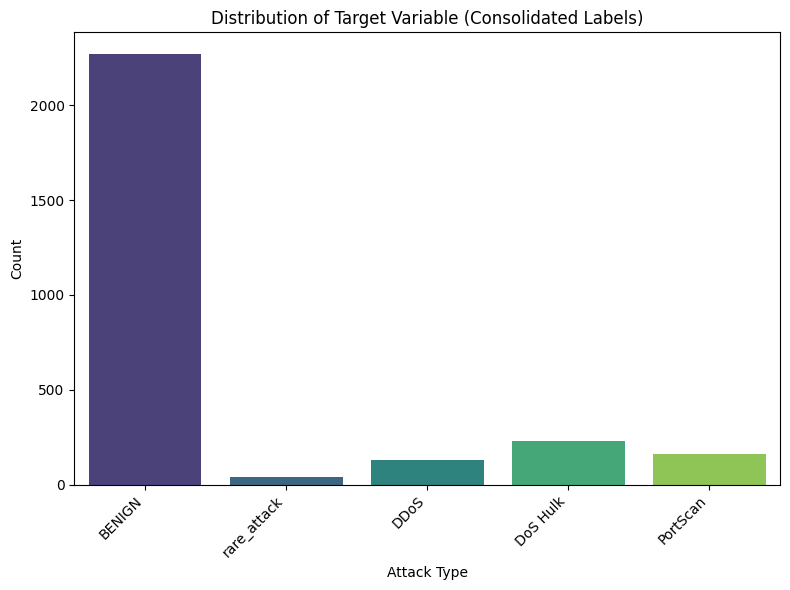

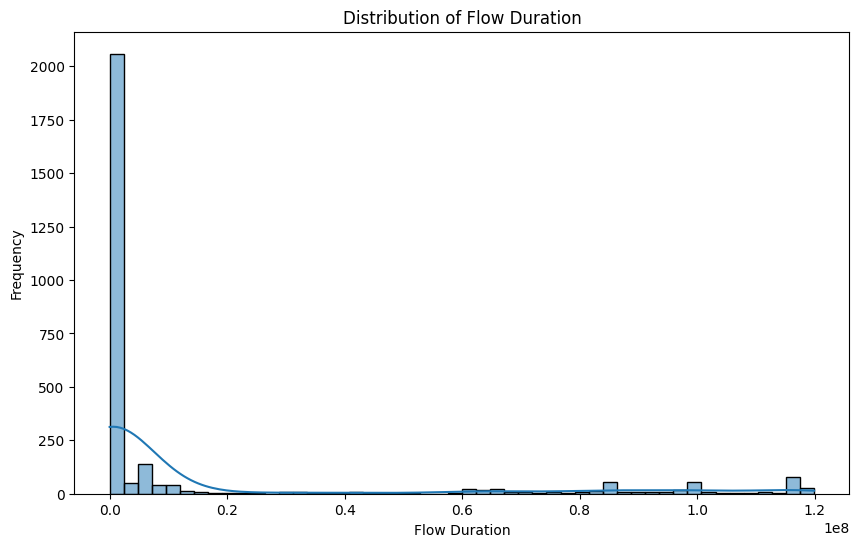

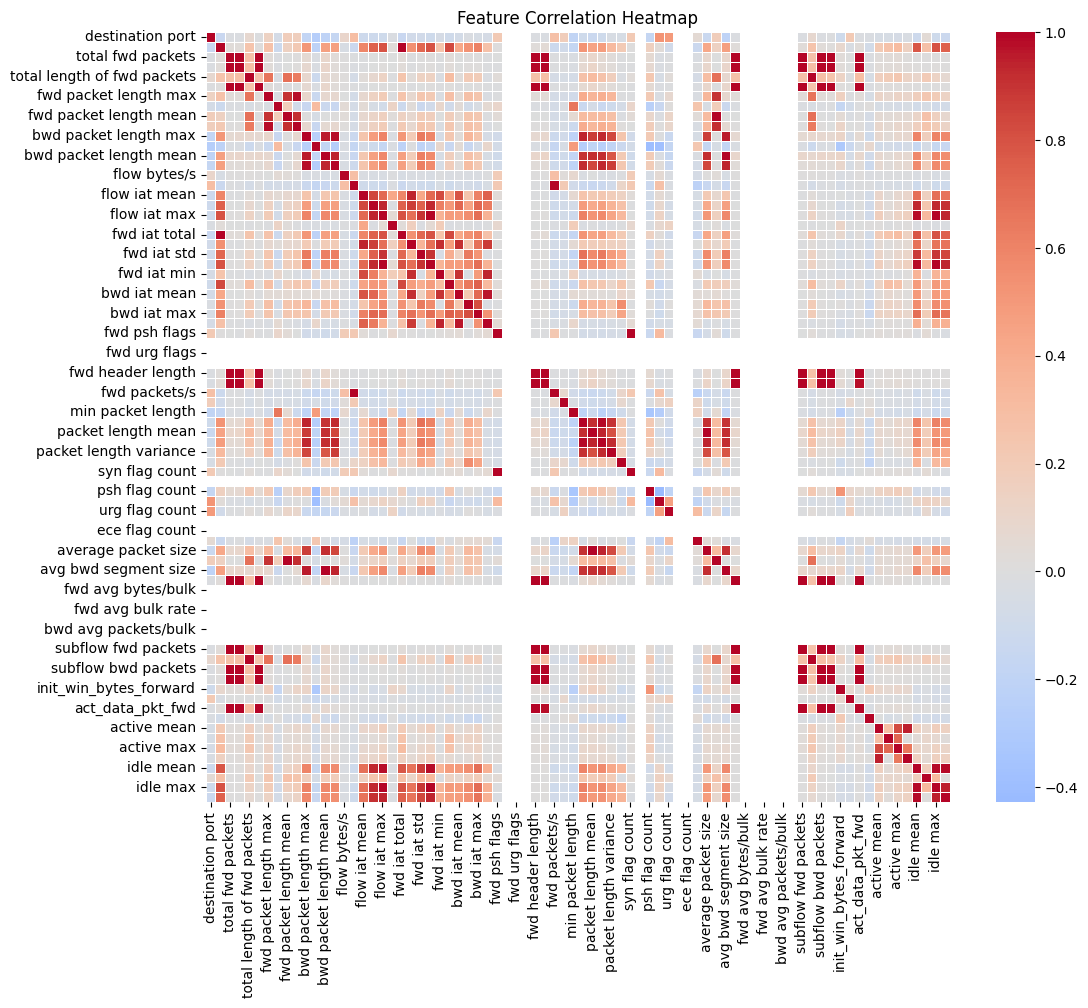


--- Histograms for Key Numerical Features ---



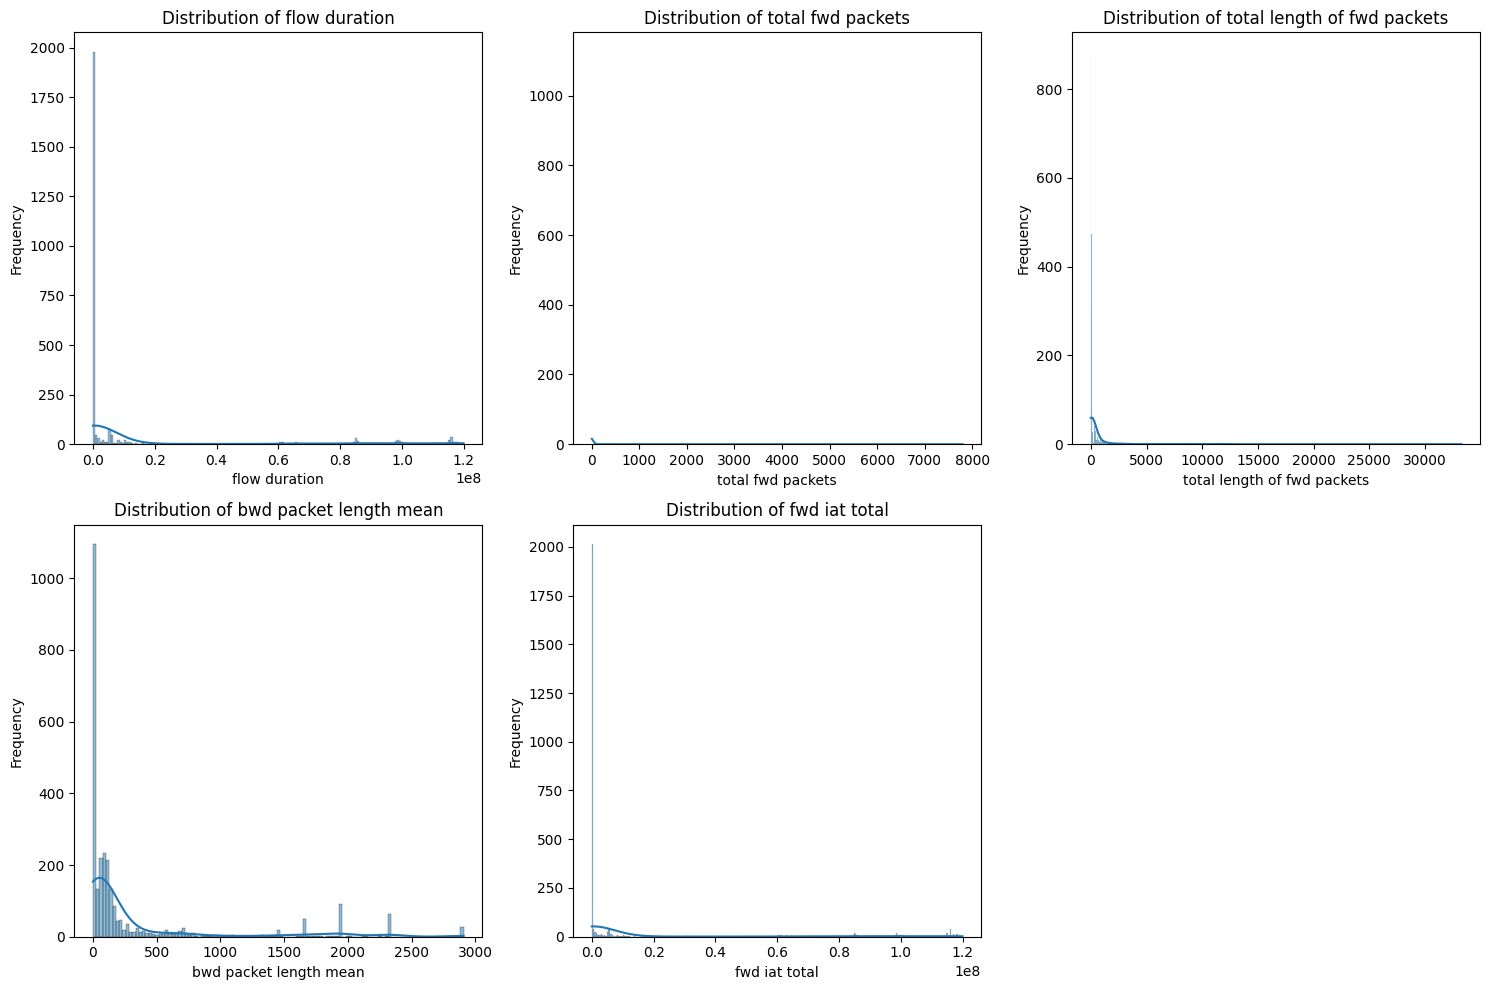


--- Box Plots for Key Numerical Features (Outlier Visualization) ---



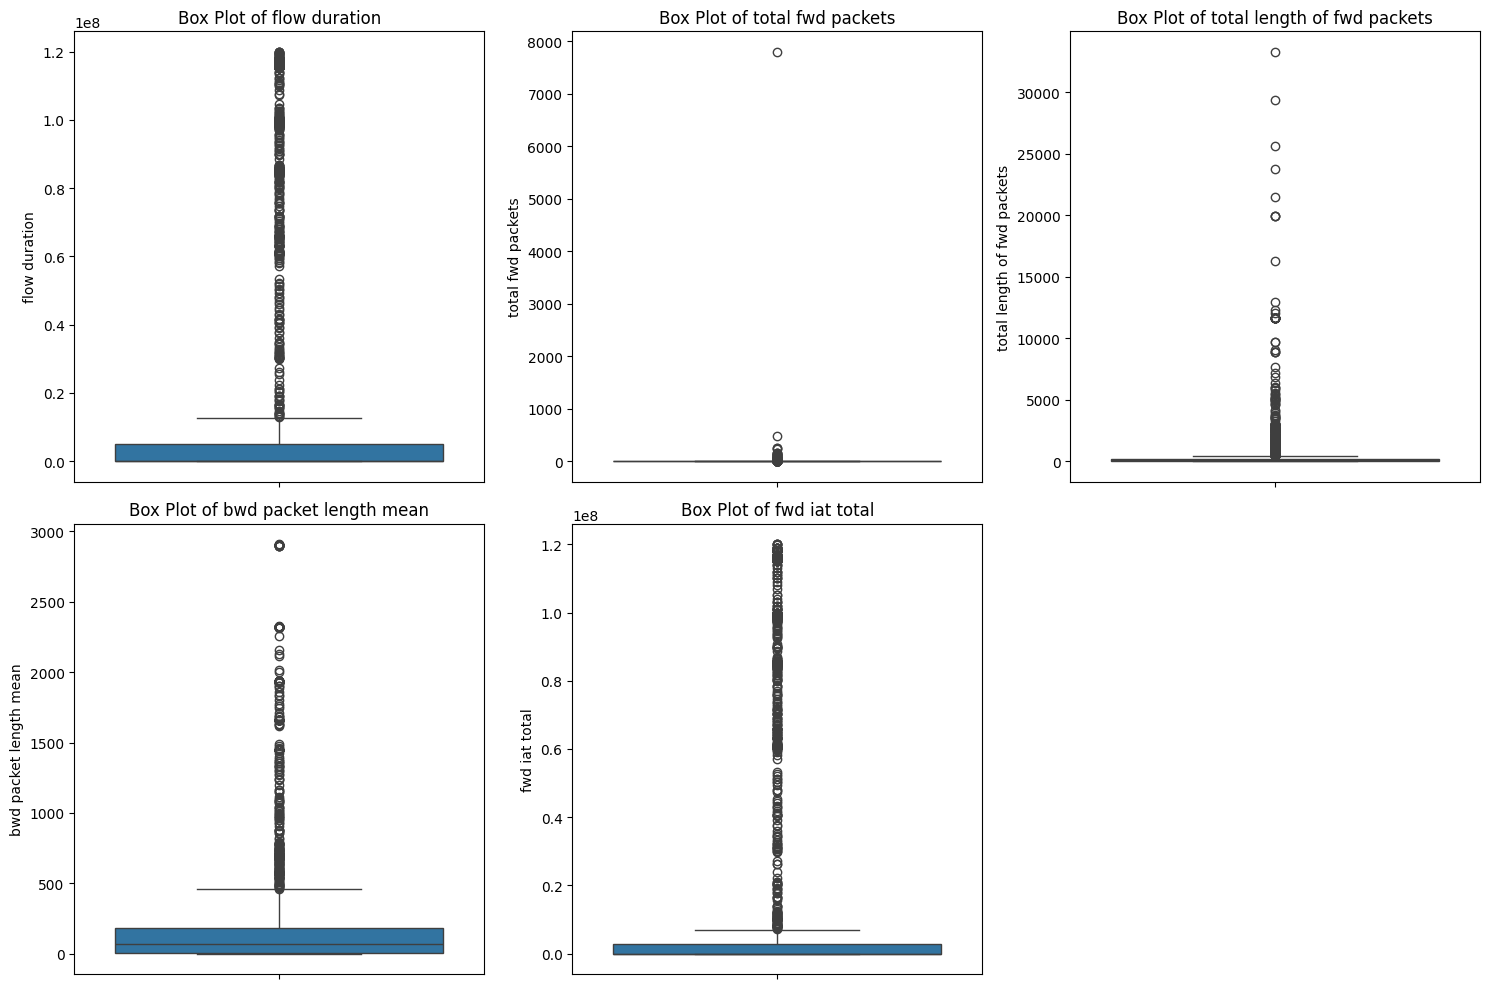


--- Pair Plot for Selected Key Features ---


<Figure size 1500x1500 with 0 Axes>

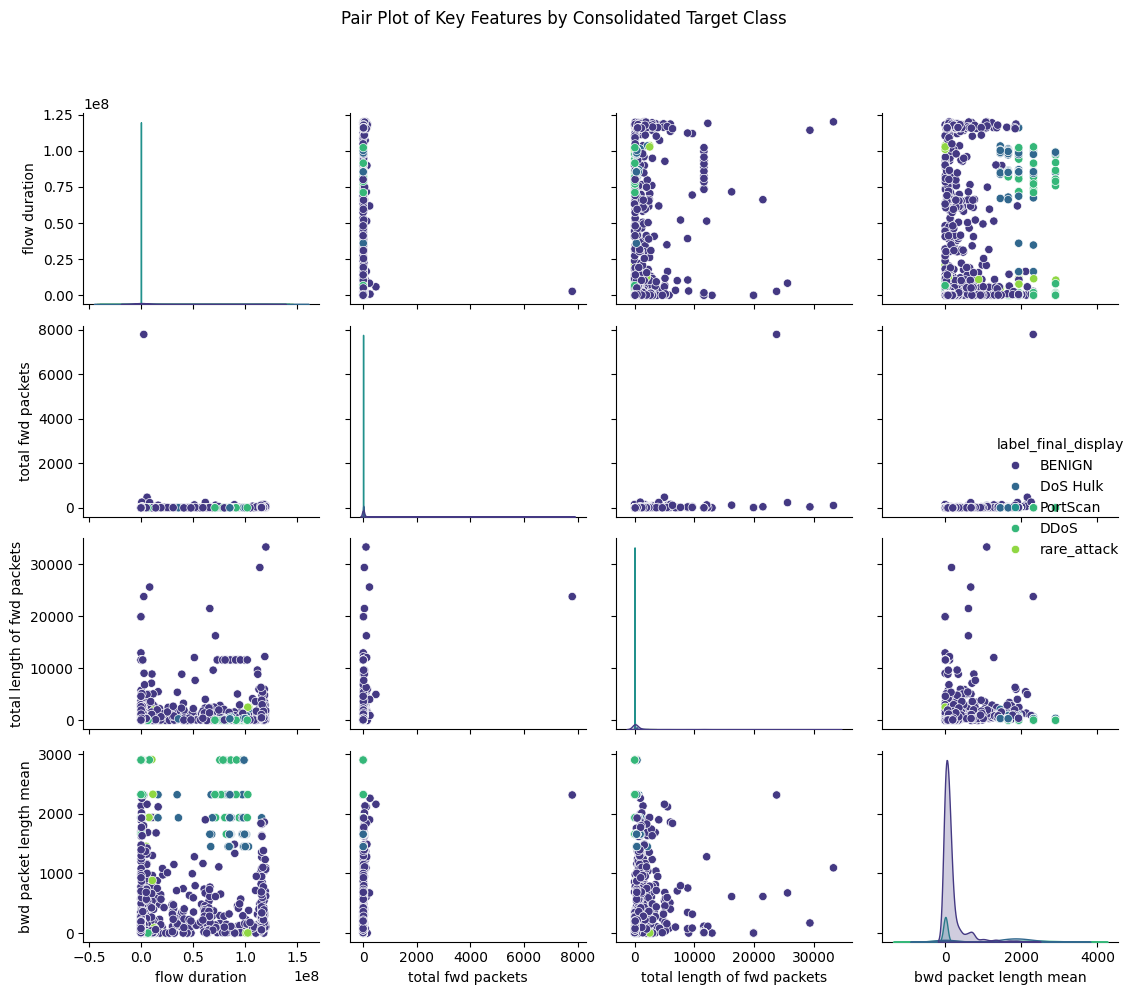


--- End Enhanced EDA ---



In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Enhanced Exploratory Data Analysis ---")
print("\nDataset Head (first 5 rows):")
print(df_subset.head())

print("\nDataset Information (Data Types and Non-Null Counts):")
df_subset.info()

print("\nDescriptive Statistics for Numerical Features:")
print(df_subset.describe())

print("\nMissing Values per Column:")
missing_values = df_subset.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

print("\nUnique values per feature (showing features with <= 10 unique values, or indicating many):")
for column in df_subset.columns:
    unique_count = df_subset[column].nunique()
    if unique_count <= 10:
        print(f"  {column}: {unique_count} unique values -> {df_subset[column].unique()}")
    else:
        print(f"  {column}: {unique_count} unique values (many)")

print("\n--- Visual EDA ---")
# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='label_final_display', data=df_subset, palette='viridis') # Using a palette for better visuals
plt.title('Distribution of Target Variable (Consolidated Labels)') # Updated title
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()

# Example: Distribution of a numerical feature (e.g., 'flow duration')
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['flow duration'], bins=50, kde=True)
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
corr = df_subset.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5, annot=False) # annot=False for cleaner view with many features
plt.title("Feature Correlation Heatmap")
plt.show()

# Histograms for selected numerical features
print("\n--- Histograms for Key Numerical Features ---\n")
selected_features_for_hist = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean',
    'fwd iat total'
]

# OPTIMIZATION: Sample data for plotting histograms to improve speed
plot_sample_size = min(len(df_subset), 20000) # Sample up to 20,000 data points for plotting
df_plot_sample = df_subset.sample(n=plot_sample_size, random_state=SEED)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_plot_sample[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Box Plots for Key Numerical Features (Outlier Visualization) ---\n")
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_plot_sample[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

print("\n--- Pair Plot for Selected Key Features ---")

# Define a very small, highly relevant subset of features for pairplot
pairplot_features = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean',
    'label_final_display' # Include the target variable for class separation visualization
]

# Ensure the sample size is manageable for pairplot
pairplot_sample_size = min(len(df_subset), 5000) # Even smaller sample for pairplot if needed
df_pairplot_sample = df_subset.sample(n=pairplot_sample_size, random_state=SEED)

plt.figure(figsize=(15, 15))
sns.pairplot(df_pairplot_sample[pairplot_features], hue='label_final_display', diag_kind='kde', palette='viridis') # hue by target
plt.suptitle('Pair Plot of Key Features by Consolidated Target Class', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

print("\n--- End Enhanced EDA ---\n")

## 3. Train/Test Split
This section performs the crucial Train/Test Split for the dataset. It divides the features (X) and the numerically encoded target variable (y) into training and testing sets, ensuring a stratified split to maintain the original class proportions in both sets. It then verifies the success of the stratification by displaying and visualizing the proportion of top 5 classes across the full dataset, training set, and test set.

--- Train/Test Split ---
X_train shape: (2262, 78)
X_test shape: (566, 78)
y_train shape: (2262,)
y_test shape: (566,)
Class names (from final_label_encoder): ['BENIGN' 'DDoS' 'DoS Hulk' 'PortScan' 'rare_attack']

--- Target Variable Distribution Across Splits ---


<Figure size 1200x700 with 0 Axes>

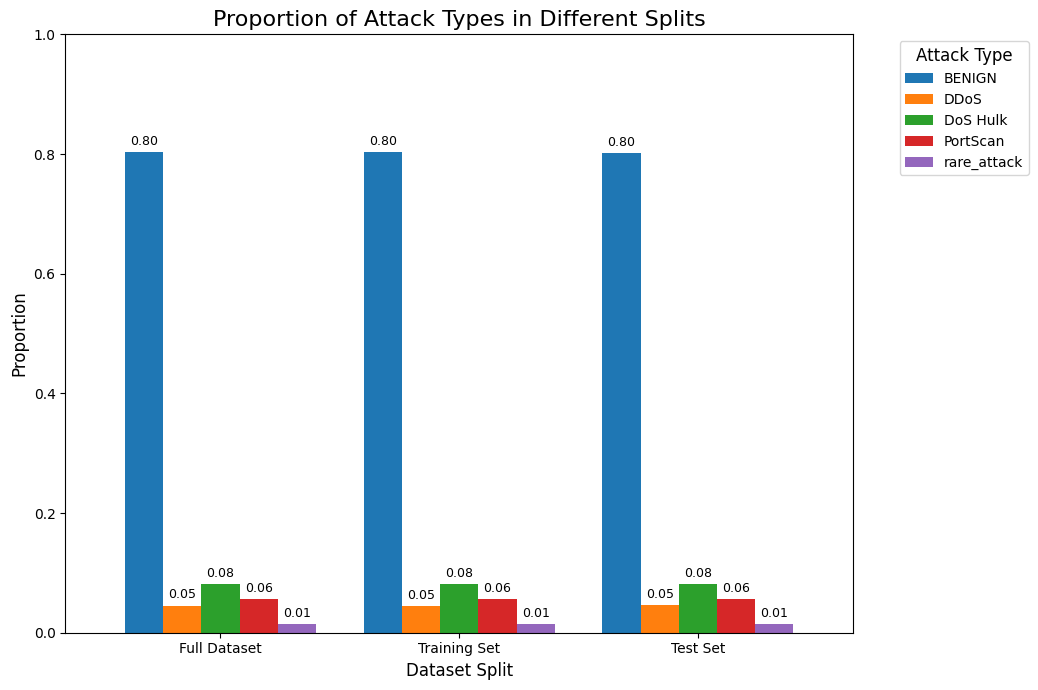


--- End Target Variable Distribution Check ---


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle # Required to load final_label_encoder if it's not in scope from previous cells
import os # Required for os.path.exists if loading from file

print("--- Train/Test Split ---")

# Perform the train-test split using the already numerically encoded 'y'
# 'y' here should be the numerical target created by final_label_encoder in the first stage.
X_train, X_test, y_train, y_test = train_test_split(X, y, # X is features, y is already encoded target
                                                    test_size=0.2,
                                                    stratify=y, # Stratify by the already encoded 'y'
                                                    random_state=SEED) # Ensure SEED is defined from previous cells

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Ensure final_label_encoder is available for inverse mapping ---
# If final_label_encoder is not directly available from the previous cell's execution, load it.
if 'final_label_encoder' not in locals():
    try:
        checkpoints_dir = './model_checkpoints' # Ensure this path is correct
        # --- FIX: Changed filename to match what was saved in the first stage ---
        with open(os.path.join(checkpoints_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder from ./model_checkpoints/final_label_encoder.pkl")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Cannot display class names or plot distribution correctly.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    print(f"Class names (from final_label_encoder): {final_label_encoder.classes_}")
else:
    print("Warning: final_label_encoder not available. Cannot display class names.")


print("\n--- Target Variable Distribution Across Splits ---")

if final_label_encoder is not None:
    y_distribution_df = pd.DataFrame({
        # Use 'y' (the numerically encoded full dataset target) for Full Dataset distribution
        'Full Dataset': pd.Series(y).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Training Set': pd.Series(y_train).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Test Set': pd.Series(y_test).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_)))
    }).T

    # If some classes have 0 occurrences in a split after reindexing, fill with 0
    y_distribution_df = y_distribution_df.fillna(0)

    plt.figure(figsize=(12, 7)) # Adjust figure size
    ax = y_distribution_df.plot(kind='bar', figsize=(12, 7), rot=0, width=0.8) # Adjust width for better visual

    plt.title("Proportion of Attack Types in Different Splits", fontsize=16)
    plt.xlabel("Dataset Split", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Attack Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
    plt.ylim(0, 1)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

else:
    print("Skipping target variable distribution plot as final_label_encoder is not available.")

print("\n--- End Target Variable Distribution Check ---")

## 4. Feature Engineering
This section performs Feature Engineering and Resampling. It preprocesses the data by capping outliers, scaling features, and reducing dimensionality with PCA, visualized via component loadings. Finally, it addresses class imbalance in the training set using SMOTE to create a balanced dataset for model training.


--- Defining and Applying Preprocessing Pipeline ---
X_train_processed shape (after scaling, IQR, PCA): (2262, 7)
X_test_processed shape (after scaling, IQR, PCA): (566, 7)
Preprocessing pipeline saved to ./model_checkpoints/preprocessor.joblib
SHAP background data (sampled X_train_processed) saved to ./model_checkpoints/X_train_processed_for_shap_background.joblib

Original Feature Names (before PCA):
['destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd

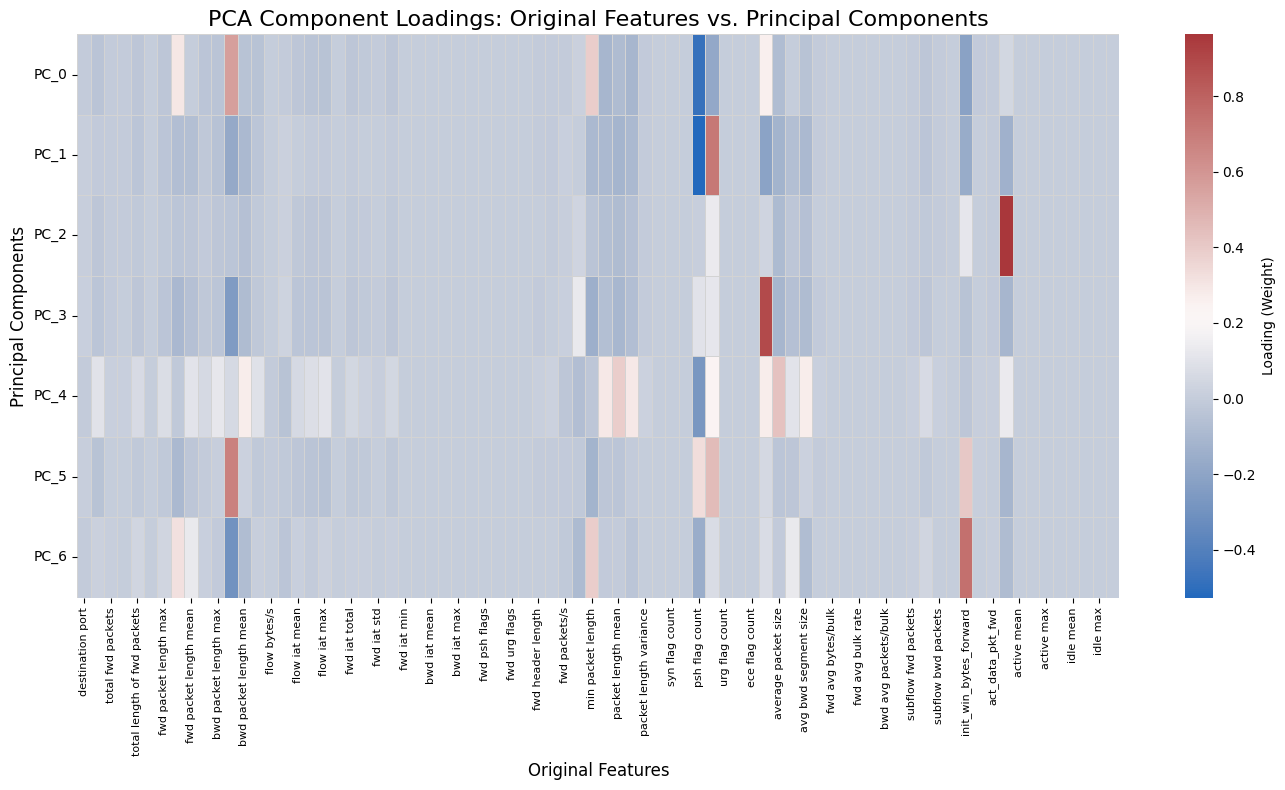


--- Interpretation of Heatmap: ---
- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).
- **Color Hue (Red/Blue):**
  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.
  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.
- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.
- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.

--- Applying SMOTE for Class Imbalance ---
Shape of X_train after SMOTE: (9085, 7)
Shape of y_train after SMOTE: (9085,)
Class distribution after SMOTE:
0    1817
1    1817
2    1817
3    1817
4    1817
Name: count, dtype: int64

--- Targe

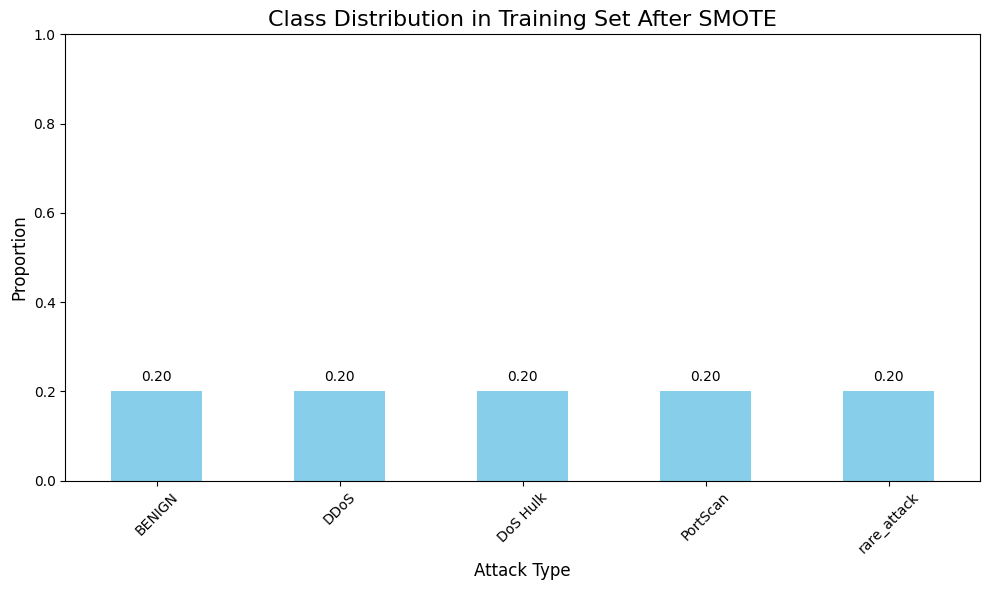


--- End Feature Engineering & Resampling ---


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
import pickle
import os
import joblib # Added joblib for saving pipelines

# Custom Transformer for IQR-based Outlier Capping
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        # Calculate Q1, Q3, and IQR for each feature (column)
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - self.factor * IQR
        self.upper_bound = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        # Clip values to the calculated bounds for each feature
        return np.clip(X, self.lower_bound, self.upper_bound)

print("\n--- Defining and Applying Preprocessing Pipeline ---")
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Standardize features
    ('iqr_capper', IQROutlierCapper(factor=1.5)), # Cap outliers
    ('pca', PCA(n_components=0.95))       # Apply PCA, retaining 95% of variance
])

# Fit the pipeline on training data and transform both training and test data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"X_train_processed shape (after scaling, IQR, PCA): {X_train_processed.shape}")
print(f"X_test_processed shape (after scaling, IQR, PCA): {X_test_processed.shape}")

# --- NEW: Save the fitted preprocessing pipeline ---
preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor.joblib')
joblib.dump(preprocessing_pipeline, preprocessor_path)
print(f"Preprocessing pipeline saved to {preprocessor_path}")

# --- NEW: Save a small sample of X_train_processed for SHAP background data ---
# This is crucial for KernelExplainer and DeepExplainer in the prediction stage
shap_background_sample_size = min(500, X_train_processed.shape[0]) # Limit size for efficiency
np.random.seed(SEED) # Ensure reproducibility
if X_train_processed.shape[0] > 0:
    indices = np.random.choice(X_train_processed.shape[0], shap_background_sample_size, replace=False)
    X_train_processed_for_shap_background = X_train_processed[indices]
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background.joblib')
    joblib.dump(X_train_processed_for_shap_background, shap_background_path)
    print(f"SHAP background data (sampled X_train_processed) saved to {shap_background_path}")
else:
    print("Warning: X_train_processed is empty. Cannot save SHAP background data.")


# Get original feature names from X_train (assuming X_train is a Pandas DataFrame)
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns.tolist()
else:
    # Fallback for NumPy arrays if X_train is not a DataFrame
    num_original_features = X_train.shape[1]
    original_feature_names = [f'Original_Feature_{i}' for i in range(num_original_features)]

print(f"\nOriginal Feature Names (before PCA):")
print(original_feature_names)

# Print the features (Principal Components) remaining after PCA
num_pca_components = X_train_processed.shape[1]
pca_features = [f'PC_{i}' for i in range(num_pca_components)]
print(f"\nFeatures remaining after PCA (Principal Components):")
print(pca_features)


print("\n--- Mapping of Principal Components to Original Features (PCA Loadings) ---")
# Access the fitted PCA model from the pipeline
pca_model = preprocessing_pipeline.named_steps['pca']

# The components_ attribute holds the principal components (eigenvectors)
# Each row is a principal component, and columns are original features
pca_loadings = pd.DataFrame(pca_model.components_,
                             columns=original_feature_names,
                             index=pca_features)

print("This table shows the 'loadings' or 'weights' of each original feature on each Principal Component:")
print(pca_loadings)

print("\nInterpretation Notes:")
print("- Each row represents a Principal Component (e.g., PC_0).")
print("- Each column represents an Original Feature.")
print("- The values in the table indicate how much each original feature contributes to each Principal Component.")
print("- Larger absolute values (positive or negative) mean a stronger contribution.")
print("- For example, looking at PC_0, features with the largest absolute values are the most influential in defining PC_0.")


# --- VISUALIZATION START ---
plt.figure(figsize=(14, max(8, num_pca_components * 0.8))) # Adjust figure size dynamically
sns.heatmap(pca_loadings, cmap='vlag', annot=False, fmt=".2f", linewidths=.5, linecolor='lightgray',
            cbar_kws={'label': 'Loading (Weight)'})
plt.title('PCA Component Loadings: Original Features vs. Principal Components', fontsize=16)
plt.xlabel('Original Features', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.xticks(rotation=90, fontsize=8) # Rotate labels for readability
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Heatmap: ---")
print("- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).")
print("- **Color Hue (Red/Blue):**")
print("  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.")
print("  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.")
print("- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.")
print("- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.")
# --- VISUALIZATION END ---

print("\n--- Applying SMOTE for Class Imbalance ---")
# Apply SMOTE to the processed training data only
smote = SMOTE(random_state=SEED, sampling_strategy='auto', k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print(f"Shape of X_train after SMOTE: {X_train_res.shape}")
print(f"Shape of y_train after SMOTE: {y_train_res.shape}")
print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\n--- Target Variable Distribution After SMOTE ---")

# Ensure final_label_encoder is available for inverse mapping for the plot
if 'final_label_encoder' not in locals():
    try:
        # Robustly define checkpoint_dir here too if needed, though assumed from above
        # checkpoint_dir = './model_checkpoints'
        # --- FIX: Corrected filename to match what was saved in the first stage ---
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for SMOTE plot.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found for SMOTE plot. Cannot map numerical labels to names.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    # Create a Series from y_train_res and get normalized value counts
    smote_distribution = pd.Series(y_train_res).value_counts(normalize=True)

    # Reindex to ensure all classes are present and use original class names from final_label_encoder
    smote_distribution = smote_distribution.reindex(range(len(final_label_encoder.classes_))).fillna(0)
    smote_distribution.index = final_label_encoder.classes_ # Map numerical labels back to original names

    plt.figure(figsize=(10, 6))
    ax = smote_distribution.plot(kind='bar', color='skyblue', rot=45)

    plt.title("Class Distribution in Training Set After SMOTE", fontsize=16)
    plt.xlabel("Attack Type", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.ylim(0, 1) # Proportions range from 0 to 1
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=5)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping SMOTE distribution plot as final_label_encoder is not available.")

print("\n--- End Feature Engineering & Resampling ---")

## 5. Classification ML Modeling
This section focuses on training and initial evaluation of various machine learning and deep learning models for multi-class classification. It establishes a baseline with a Dummy Classifier, then trains untuned Logistic Regression, Random Forest, and XGBoost models, performing cross-validation for robust assessment. Finally, it defines, trains, and evaluates Feedforward Neural Network (FFN) and Long Short-Term Memory (LSTM) models using PyTorch. All models are evaluated on the processed test set using metrics like F1-score and ROC AUC, and then saved.

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder # Explicitly import if needed for dummy data or initial setup
import joblib
import os


# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        # --- FIX: Corrected filename for loading ---
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None


# --- Baseline Model (Dummy Classifier) ---
print("\n--- Training Baseline Model (Dummy Classifier) ---")
dummy_model = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_model.fit(X_train_res, y_train_res)

# Checkpoint 1: Save Dummy Classifier
dummy_model_path = os.path.join(checkpoint_dir, "dummy_model.pkl")
joblib.dump(dummy_model, dummy_model_path)
print(f"Checkpoint: Dummy Classifier saved to {dummy_model_path}")

y_pred_dummy = dummy_model.predict(X_test_processed)

print("\nClassification Report for Baseline Model:")
unique_test_labels = np.unique(y_test)
if final_label_encoder is not None: # Use final_label_encoder
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)} # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_dummy, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_dummy, zero_division=0))


# Define simplified "pipelines" (just the model) since preprocessing is already done on X_train_res and X_test_processed
print("\n--- Defining Model 'Pipelines' (Model Only) ---")

# --- Logistic Regression ---
pipeline_lr = Pipeline([
    ('model', LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=SEED, n_jobs=-1))
])

# --- Random Forest Classifier ---
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1, class_weight='balanced'))
])

# --- XGBoost Classifier ---
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='multi:softmax',
                                 eval_metric='mlogloss',
                                 num_class=len(final_label_encoder.classes_), # Use final_label_encoder
                                 n_estimators=100, random_state=SEED, n_jobs=-1, tree_method='hist')) # Removed gpu_id=0 for broader compatibility if GPU not present
])

# --- Logistic Regression Training and CV ---
print("\n--- Training Logistic Regression Model Pipeline ---")
pipeline_lr.fit(X_train_res, y_train_res)

# Checkpoint 2: Save Logistic Regression Pipeline
lr_pipeline_path = os.path.join(checkpoint_dir, "logistic_regression_pipeline.pkl")
joblib.dump(pipeline_lr, lr_pipeline_path)
print(f"Checkpoint: Logistic Regression Pipeline saved to {lr_pipeline_path}")

y_pred_lr = pipeline_lr.predict(X_test_processed)
# y_prob_lr = pipeline_lr.predict_proba(X_test_processed) # This line is commented out but left if user intends to use it later

print("\n--- Cross-Validation for Logistic Regression Pipeline ---")
cv_scores_lr = cross_val_score(pipeline_lr, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=0)
print(f"Logistic Regression CV F1-scores (Macro): {cv_scores_lr}")
print(f"Logistic Regression Mean CV F1-score (Macro): {np.mean(cv_scores_lr):.4f} (+/- {np.std(cv_scores_lr):.4f})")
print("\nClassification Report for Logistic Regression:")
if final_label_encoder is not None: # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_lr, zero_division=0))


# --- Random Forest Classifier Training and CV ---
print("\n--- Training Random Forest Model Pipeline ---")
pipeline_rf.fit(X_train_res, y_train_res)

# Checkpoint 3: Save Random Forest Pipeline
rf_pipeline_path = os.path.join(checkpoint_dir, "random_forest_pipeline.pkl")
joblib.dump(pipeline_rf, rf_pipeline_path)
print(f"Checkpoint: Random Forest Pipeline saved to {rf_pipeline_path}")

y_pred_rf = pipeline_rf.predict(X_test_processed)
# y_prob_rf = pipeline_rf.predict_proba(X_test_processed) # This line is commented out but left if user intends to use it later

print("\n--- Cross-Validation for Random Forest Pipeline ---")
cv_scores_rf = cross_val_score(pipeline_rf, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1_macro',
                               n_jobs=-1,
                               verbose=0)
print(f"Random Forest CV F1-scores (Macro): {cv_scores_rf}")
print(f"Random Forest Mean CV F1-score (Macro): {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf):.4f})")
print("\nClassification Report for Random Forest:")
if final_label_encoder is not None: # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_rf, zero_division=0))

# --- XGBoost Classifier Training and CV ---
print("\n--- Training Initial XGBoost Model Pipeline ---")
pipeline_xgb.fit(X_train_res, y_train_res)

# Checkpoint 4: Save XGBoost Pipeline
xgb_pipeline_path = os.path.join(checkpoint_dir, "xgboost_pipeline.pkl")
joblib.dump(pipeline_xgb, xgb_pipeline_path)
print(f"Checkpoint: XGBoost Pipeline saved to {xgb_pipeline_path}")

y_pred_xgb = pipeline_xgb.predict(X_test_processed)
# y_prob_xgb = pipeline_xgb.predict_proba(X_test_processed) # This line is commented out but left if user intends to use it later

print("\n--- Cross-Validation for Initial XGBoost Model Pipeline ---")
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train_res, y_train_res,
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                 scoring='f1_macro',
                                 n_jobs=-1,
                                 verbose=0)
print(f"Initial XGBoost CV F1-scores (Macro): {cv_scores_xgb}")
print(f"Initial XGBoost Mean CV F1-score (Macro): {np.mean(cv_scores_xgb):.4f} (+/- {np.std(cv_scores_xgb):.4f})")
print("\nClassification Report for XGBoost:")
if final_label_encoder is not None: # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_xgb, zero_division=0))


# --- PyTorch Neural Networks (FFN and LSTM) ---

num_classes = len(final_label_encoder.classes_) # Use final_label_encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device for PyTorch models: {device}")

X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


# Define simple feedforward network
class FFN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define RNN (LSTM) Model
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # input_size should be 1 if each feature is a separate time step.
        # If you meant to feed the entire feature vector at once, input_size should be input_dim.
        # Current unsqueeze(-1) implies input_size=1
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Reshape x for LSTM: (batch_size, sequence_length, input_size)
        # Here, sequence_length is number of features (PCA components), input_size is 1
        x = x.unsqueeze(-1) # Adds a dimension for input_size=1

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Take output from the last time step
        return out


# Instantiate and train FFN
print("\n--- Training Feedforward Neural Network ---")
ffn_model = FFN(X_train_res.shape[1], num_classes).to(device)
criterion_ffn = nn.CrossEntropyLoss()
optimizer_ffn = optim.Adam(ffn_model.parameters(), lr=0.001)

epochs_ffn = 30
ffn_model.train()
ffn_train_losses = []
for epoch in range(epochs_ffn):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_ffn.zero_grad()
        outputs = ffn_model(batch_X)
        loss = criterion_ffn(outputs, batch_y)
        loss.backward()
        optimizer_ffn.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    ffn_train_losses.append(avg_epoch_loss)
    print(f"FFN Epoch {epoch+1}/{epochs_ffn}, Loss: {avg_epoch_loss:.4f}")

# Checkpoint 5: Save FFN Model
ffn_model_path = os.path.join(checkpoint_dir, "ffn_model_state_dict.pth")
torch.save(ffn_model.state_dict(), ffn_model_path)
print(f"Checkpoint: FFN model state_dict saved to {ffn_model_path}")

ffn_model.eval()
with torch.no_grad():
    X_test_tensor_ffn = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    y_pred_logits_ffn = ffn_model(X_test_tensor_ffn).cpu().numpy()
    y_pred_labels_ffn = np.argmax(y_pred_logits_ffn, axis=1)

print("\nClassification Report for FFN:")
if final_label_encoder is not None: # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_labels_ffn, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_labels_ffn, zero_division=0))


# Instantiate and train LSTMNet
print("\n--- Training Recurrent Neural Network (LSTM) ---")
input_dim_lstm = X_train_res.shape[1] # Number of features (PCA components)
hidden_dim_lstm = 64
num_layers_lstm = 1

lstm_model = LSTMNet(input_dim_lstm, hidden_dim_lstm, num_layers_lstm, num_classes).to(device)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

epochs_lstm = 50
lstm_model.train()
lstm_train_losses = []
for epoch in range(epochs_lstm):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion_lstm(outputs, batch_y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    lstm_train_losses.append(avg_epoch_loss)
    print(f"LSTM Epoch {epoch+1}/{epochs_lstm}, Loss: {avg_epoch_loss:.4f}")

# Checkpoint 6: Save LSTM Model
lstm_model_path = os.path.join(checkpoint_dir, "lstm_model_state_dict.pth")
torch.save(lstm_model.state_dict(), lstm_model_path)
print(f"Checkpoint: LSTM model state_dict saved to {lstm_model_path}")

lstm_model.eval()
with torch.no_grad():
    X_test_tensor_lstm = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    y_pred_logits_lstm = lstm_model(X_test_tensor_lstm).cpu().numpy()
    y_pred_labels_lstm = np.argmax(y_pred_logits_lstm, axis=1)

print("\nClassification Report for LSTM:")
if final_label_encoder is not None: # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
    print(classification_report(y_test, y_pred_labels_lstm, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print("Warning: final_label_encoder not available. Using default target names for classification report.")
    print(classification_report(y_test, y_pred_labels_lstm, zero_division=0))


--- Training Baseline Model (Dummy Classifier) ---
Checkpoint: Dummy Classifier saved to ./model_checkpoints/dummy_model.pkl

Classification Report for Baseline Model:
              precision    recall  f1-score   support

      BENIGN       0.80      1.00      0.89       454
        DDoS       0.00      0.00      0.00        26
    DoS Hulk       0.00      0.00      0.00        46
    PortScan       0.00      0.00      0.00        32
 rare_attack       0.00      0.00      0.00         8

    accuracy                           0.80       566
   macro avg       0.16      0.20      0.18       566
weighted avg       0.64      0.80      0.71       566


--- Defining Model 'Pipelines' (Model Only) ---

--- Training Logistic Regression Model Pipeline ---
Checkpoint: Logistic Regression Pipeline saved to ./model_checkpoints/logistic_regression_pipeline.pkl

--- Cross-Validation for Logistic Regression Pipeline ---
Logistic Regression CV F1-scores (Macro): [0.78267601 0.79645917 0.77154726 0.

## 6(a). Hyperparameter Tuning
This section focuses on Hyperparameter Tuning for the previously defined Logistic Regression, Random Forest, and XGBoost models. Using GridSearchCV with stratified cross-validation and F1-score as the primary metric, it systematically searches for the optimal hyperparameters for each model. The best-performing tuned models are then saved and their performance is reported on the test set using detailed classification reports.

In [18]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import xgboost as xgb
import numpy as np
import os
import joblib
import pandas as pd # Ensure pandas is imported if not already


# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None: # Use final_label_encoder
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)} # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = None # Let classification_report handle default if needed


print("\n--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---")

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga'],
    'model__penalty': ['l2']
}

grid_search_lr_pipeline = GridSearchCV(estimator=pipeline_lr,
                                       param_grid=param_grid_lr,
                                       scoring='f1_macro',
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on your processed and resampled training data
grid_search_lr_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Logistic Regression Pipeline: {grid_search_lr_pipeline.best_params_}")
print(f"Best cross-validation F1-score (Macro) for Logistic Regression: {grid_search_lr_pipeline.best_score_:.4f}")

# Store the best performing Logistic Regression model (which is part of a pipeline)
best_lr_model_pipeline = grid_search_lr_pipeline.best_estimator_

# Checkpoint 1: Save Tuned Logistic Regression Pipeline
tuned_lr_pipeline_path = os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl")
joblib.dump(best_lr_model_pipeline, tuned_lr_pipeline_path)
print(f"Checkpoint: Tuned Logistic Regression Pipeline saved to {tuned_lr_pipeline_path}")


# Make predictions on the preprocessed test set
y_pred_best_lr = best_lr_model_pipeline.predict(X_test_processed)

print("\nClassification Report for Best Tuned Logistic Regression Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_lr, zero_division=0))


print("\n--- Hyperparameter Tuning for Random Forest Pipeline (GridSearchCV) ---")

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf_pipeline = GridSearchCV(estimator=pipeline_rf,
                                       param_grid=param_grid_rf,
                                       scoring='f1_macro',
                                       cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on X_train_res, y_train_res
grid_search_rf_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Random Forest Pipeline: {grid_search_rf_pipeline.best_params_}")
print(f"Best cross-validation F1-score (Macro) for Random Forest: {grid_search_rf_pipeline.best_score_:.4f}")

best_rf_model_pipeline = grid_search_rf_pipeline.best_estimator_

# Checkpoint 2: Save Tuned Random Forest Pipeline
tuned_rf_pipeline_path = os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl")
joblib.dump(best_rf_model_pipeline, tuned_rf_pipeline_path)
print(f"Checkpoint: Tuned Random Forest Pipeline saved to {tuned_rf_pipeline_path}")

y_pred_best_rf = best_rf_model_pipeline.predict(X_test_processed)

print("\nClassification Report for Best Tuned Random Forest Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_rf, zero_division=0))


# Hyperparameter tuning for XGBoost Pipeline
print("\n--- Hyperparameter Tuning for XGBoost Pipeline (GridSearchCV) ---")

param_grid_pipeline_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.7, 1.0]
}

grid_search_xgb_pipeline = GridSearchCV(estimator=pipeline_xgb,
                                        param_grid=param_grid_pipeline_xgb,
                                        scoring='f1_macro',
                                        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                                        verbose=0, n_jobs=-1)

# Fit GridSearchCV on X_train_res, y_train_res (already processed and resampled)
grid_search_xgb_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for XGBoost Pipeline: {grid_search_xgb_pipeline.best_params_}")
best_xgb_model_pipeline = grid_search_xgb_pipeline.best_estimator_

# Checkpoint 3: Save Tuned XGBoost Pipeline
tuned_xgb_pipeline_path = os.path.join(checkpoint_dir, "tuned_xgboost_pipeline.pkl")
joblib.dump(best_xgb_model_pipeline, tuned_xgb_pipeline_path)
print(f"Checkpoint: Tuned XGBoost Pipeline saved to {tuned_xgb_pipeline_path}")

y_pred_best_xgb = best_xgb_model_pipeline.predict(X_test_processed)
# y_prob_best_xgb = best_xgb_model_pipeline.predict_proba(X_test_processed) # This line is commented out but left if user intends to use it later

print("\nClassification Report for Best Tuned XGBoost Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_xgb, zero_division=0))


--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---

Best parameters for Logistic Regression Pipeline: {'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best cross-validation F1-score (Macro) for Logistic Regression: 0.8546
Checkpoint: Tuned Logistic Regression Pipeline saved to ./model_checkpoints/tuned_logistic_regression_pipeline.pkl

Classification Report for Best Tuned Logistic Regression Model:
              precision    recall  f1-score   support

      BENIGN       0.99      0.61      0.75       454
        DDoS       0.23      1.00      0.37        26
    DoS Hulk       0.59      0.89      0.71        46
    PortScan       0.79      0.97      0.87        32
 rare_attack       0.11      0.88      0.20         8

    accuracy                           0.67       566
   macro avg       0.54      0.87      0.58       566
weighted avg       0.90      0.67      0.73       566


--- Hyperparameter Tuning for Random Forest Pipeline (GridSea

## 6(b). Train the Ensemble Model
This section trains and evaluates a Stacking Classifier for binary classification. It leverages the previously hyperparameter-tuned Logistic Regression, Random Forest, and XGBoost models as base estimators. A Logistic Regression model acts as the meta-classifier, learning to combine the predictions of the base models. The stacking ensemble is trained using stratified cross-validation on the processed and resampled training data, then saved. Finally, its performance is evaluated on the processed test set using a classification report and ROC AUC score.

In [20]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import os
import joblib
import pandas as pd # Ensure pandas is imported if not already
import pickle # For loading label encoder if needed

print("\n--- Training Stacking Classifier ---")

# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None: # Use final_label_encoder
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)} # Use final_label_encoder
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = None # Let classification_report handle default if needed


# Define the base estimators.
estimators = [
    ('lr', best_lr_model_pipeline),
    ('rf', best_rf_model_pipeline),
    ('xgb', best_xgb_model_pipeline)
]

# Define the meta-classifier (final estimator).
meta_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=SEED, n_jobs=-1)

# Create the StackingClassifier
stacked_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
    n_jobs=-1,
    verbose=0
)

# Fit the StackingClassifier on the processed and resampled training data
print("Fitting Stacking Classifier...")
stacked_classifier.fit(X_train_res, y_train_res)
print("Stacking Classifier training complete.")

# Checkpoint 1: Save the trained Stacking Classifier
stacked_classifier_path = os.path.join(checkpoint_dir, "stacked_classifier.pkl")
joblib.dump(stacked_classifier, stacked_classifier_path)
print(f"Checkpoint: Stacking Classifier saved to {stacked_classifier_path}")

# Predict on the processed test data
y_pred_stacked = stacked_classifier.predict(X_test_processed)
# y_prob_stacked = stacked_classifier.predict_proba(X_test_processed) # This line is commented out but left if user intends to use it later

print("\nClassification Report for Stacking Classifier:")
if filtered_target_names: # Use filtered_target_names
    print(classification_report(y_test, y_pred_stacked, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_stacked, zero_division=0))


--- Training Stacking Classifier ---
Fitting Stacking Classifier...
Stacking Classifier training complete.
Checkpoint: Stacking Classifier saved to ./model_checkpoints/stacked_classifier.pkl

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

      BENIGN       0.99      0.97      0.98       454
        DDoS       1.00      1.00      1.00        26
    DoS Hulk       0.92      0.96      0.94        46
    PortScan       0.97      0.97      0.97        32
 rare_attack       0.43      0.75      0.55         8

    accuracy                           0.97       566
   macro avg       0.86      0.93      0.89       566
weighted avg       0.97      0.97      0.97       566



## 7. Comparative Performance of ML Models
This section provides a comprehensive Model Comparison and Selection for multi-class classification. It robustly loads all trained models (baseline, untuned and tuned traditional ML models, deep learning models, and the stacking classifier). For each model, it calculates and displays the F1-score for the positive class on the test set. Crucially, it then generates and plots comparative Receiver Operating Characteristic (ROC) curves and Precision-Recall (PR) curves for all models, along with their respective Area Under the Curve (AUC) and Average Precision (AP) scores. Finally, it presents a summarized ranking of all models based on their F1-score, ROC AUC, and Average Precision, aiding in the selection of the best-performing model for the task.


--- Model Comparison and Selection (Multi-Class) ---
Loaded final_label_encoder from ./model_checkpoints/final_label_encoder.pkl
Baseline Test F1-score (Macro): 0.1780
Logistic Regression (Untuned) Test F1-score (Macro): 0.5201
Logistic Regression (Tuned) Test F1-score (Macro): 0.5809
Random Forest (Untuned) Test F1-score (Macro): 0.8883
Random Forest (Tuned) Test F1-score (Macro): 0.8883
XGBoost (Tuned) Test F1-score (Macro): 0.8684
FFN Test F1-score (Macro): 0.6795
LSTM Test F1-score (Macro): 0.6845
Stacking Classifier Test F1-score (Macro): 0.8861

--- Comparative ROC and Precision-Recall Curves (Multi-Class) ---
Baseline Macro-Avg ROC AUC: 0.5000
Logistic Regression (Untuned) Macro-Avg ROC AUC: 0.9503
Logistic Regression (Tuned) Macro-Avg ROC AUC: 0.9432
Random Forest (Untuned) Macro-Avg ROC AUC: 0.9679
Random Forest (Tuned) Macro-Avg ROC AUC: 0.9679
XGBoost (Tuned) Macro-Avg ROC AUC: 0.9904
FFN Macro-Avg ROC AUC: 0.9695
LSTM Macro-Avg ROC AUC: 0.9702
Stacking Classifier Macro-Avg

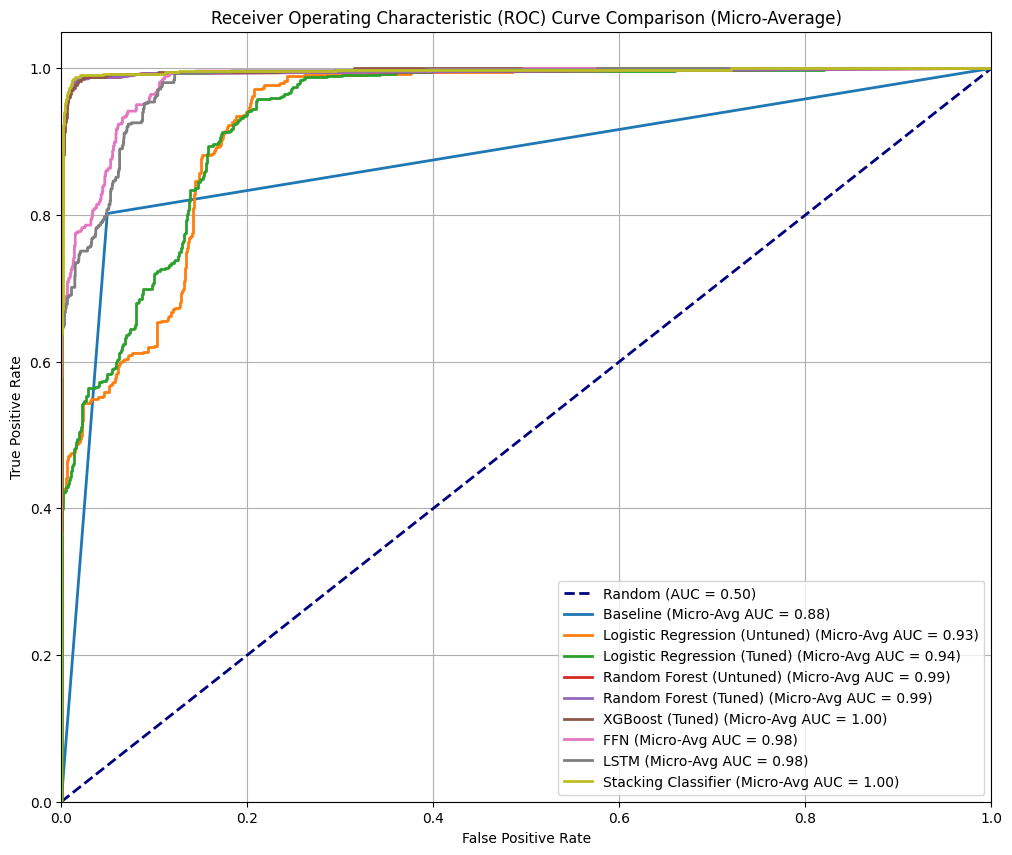

Baseline Macro-Avg AP: 0.2000
Logistic Regression (Untuned) Macro-Avg AP: 0.6139
Logistic Regression (Tuned) Macro-Avg AP: 0.6134
Random Forest (Untuned) Macro-Avg AP: 0.8957
Random Forest (Tuned) Macro-Avg AP: 0.8957
XGBoost (Tuned) Macro-Avg AP: 0.9155
FFN Macro-Avg AP: 0.7906
LSTM Macro-Avg AP: 0.7758
Stacking Classifier Macro-Avg AP: 0.9289


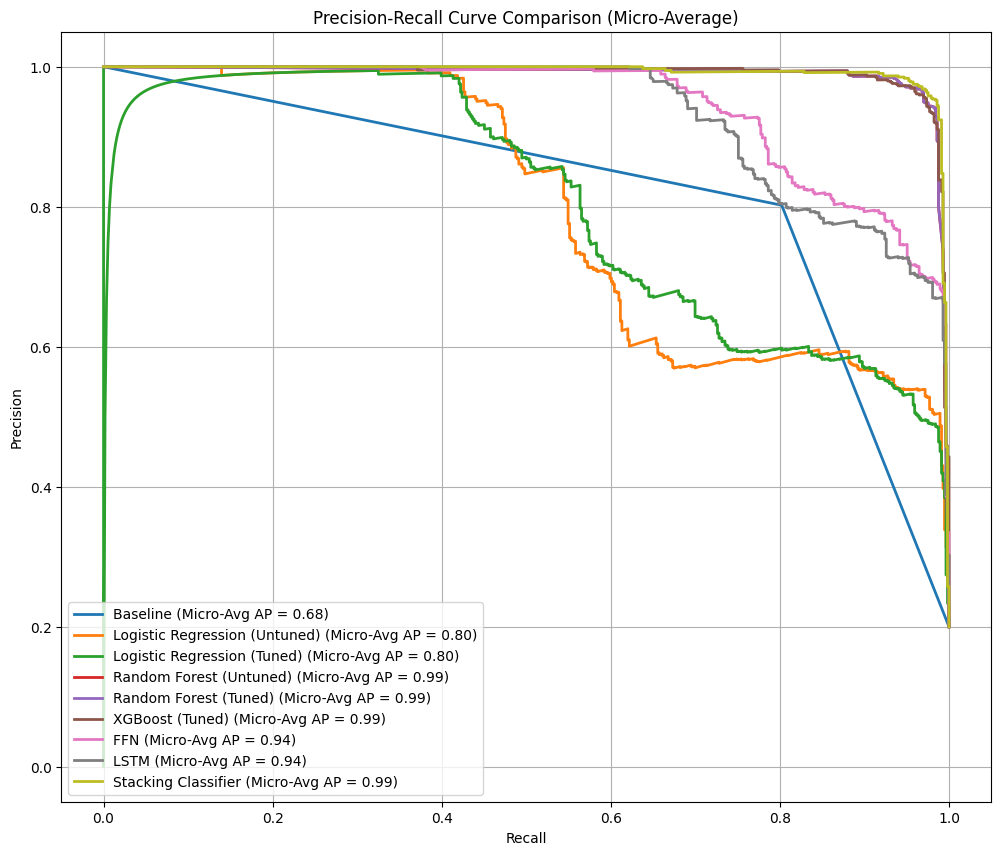

--- End Comparative Plots ---

--- Summary of Model Performance (F1-score for Multi-Class) ---
Random Forest (Untuned): F1-score (Macro-Avg) = 0.8883
Random Forest (Tuned): F1-score (Macro-Avg) = 0.8883
Stacking Classifier: F1-score (Macro-Avg) = 0.8861
XGBoost (Tuned): F1-score (Macro-Avg) = 0.8684
LSTM: F1-score (Macro-Avg) = 0.6845
FFN: F1-score (Macro-Avg) = 0.6795
Logistic Regression (Tuned): F1-score (Macro-Avg) = 0.5809
Logistic Regression (Untuned): F1-score (Macro-Avg) = 0.5201
Baseline: F1-score (Macro-Avg) = 0.1780

--- Summary of Model Performance (ROC AUC - Macro-Avg) ---
XGBoost (Tuned): ROC AUC (Macro-Avg) = 0.9904
Stacking Classifier: ROC AUC (Macro-Avg) = 0.9856
LSTM: ROC AUC (Macro-Avg) = 0.9702
FFN: ROC AUC (Macro-Avg) = 0.9695
Random Forest (Untuned): ROC AUC (Macro-Avg) = 0.9679
Random Forest (Tuned): ROC AUC (Macro-Avg) = 0.9679
Logistic Regression (Untuned): ROC AUC (Macro-Avg) = 0.9503
Logistic Regression (Tuned): ROC AUC (Macro-Avg) = 0.9432
Baseline: ROC AUC (

In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer # New import needed for multi-class ROC/PR curves
import os # For os.path.join
import joblib # For loading models
import pickle # For loading label encoder

print("\n--- Model Comparison and Selection (Multi-Class) ---")

# --- Ensure X_test_processed and y_test are defined ---
# Crucial for direct test set evaluation. If running standalone, load them.
# For a Jupyter Notebook, assume they are defined in prior cells.
if 'X_test_processed' not in locals() or 'y_test' not in locals():
    print("Error: X_test_processed or y_test not found. Cannot perform direct test set evaluation. "
          "Please ensure data splitting and preprocessing stages were run.")
    # You might want to exit or handle this more robustly if running standalone
    # For now, we'll let subsequent checks print more specific warnings.
    # Set them to None to trigger appropriate skips later
    X_test_processed = None
    y_test = None


# Ensure final_label_encoder is available
final_label_encoder = None
try:
    # Load the multi-class specific label encoder
    label_encoder_path = os.path.join(checkpoint_dir, "final_label_encoder.pkl") # Use multi-class specific name
    with open(label_encoder_path, "rb") as f:
        final_label_encoder = pickle.load(f)
    print(f"Loaded final_label_encoder from {label_encoder_path}")
except FileNotFoundError:
    print(f"Error: 'final_multiclass_label_encoder.pkl' not found in {checkpoint_dir}. Please ensure previous stages were run.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# Get class names from final_label_encoder for plotting and reports
class_names = []
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    num_classes = len(class_names)
else:
    # Fallback if encoder not loaded (should ideally not happen in a complete pipeline)
    if y_test is not None:
        class_names = [f"Class {i}" for i in range(len(np.unique(y_test)))]
        num_classes = len(class_names)
    else:
        class_names = ["Class 0", "Class 1", "Class 2"] # Default to 3 classes if no y_test
        num_classes = len(class_names)
    print(f"Warning: final_label_encoder not available. Using generic class names: {class_names}.")


# --- Load all required models and pipelines for comparison ---
loaded_models = {}

# Dummy Classifier
try:
    dummy_model = joblib.load(os.path.join(checkpoint_dir, "dummy_model.pkl")) # Use multi-class specific name
    loaded_models['dummy_model'] = dummy_model
except FileNotFoundError:
    print("Warning: dummy_multiclass_model.pkl not found. Skipping Dummy Classifier.")

# Untuned Logistic Regression
try:
    pipeline_lr = joblib.load(os.path.join(checkpoint_dir, "logistic_regression_pipeline.pkl")) # Use multi-class specific name
    loaded_models['pipeline_lr'] = pipeline_lr
except FileNotFoundError:
    print("Warning: logistic_regression_multiclass_pipeline.pkl not found. Skipping Untuned LR.")

# Tuned Logistic Regression
try:
    best_lr_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl")) # Use multi-class specific name
    loaded_models['best_lr_model_pipeline'] = best_lr_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_logistic_regression_multiclass_pipeline.pkl not found. Skipping Tuned LR.")

# Untuned Random Forest
try:
    pipeline_rf = joblib.load(os.path.join(checkpoint_dir, "random_forest_pipeline.pkl")) # Use multi-class specific name
    loaded_models['pipeline_rf'] = pipeline_rf
except FileNotFoundError:
    print("Warning: random_forest_multiclass_pipeline.pkl not found. Skipping Untuned RF.")

# Tuned Random Forest
try:
    best_rf_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl")) # Use multi-class specific name
    loaded_models['best_rf_model_pipeline'] = best_rf_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_random_forest_multiclass_pipeline.pkl not found. Skipping Tuned RF.")

# Tuned XGBoost
try:
    best_xgb_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_pipeline.pkl")) # Use multi-class specific name
    loaded_models['best_xgb_model_pipeline'] = best_xgb_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_xgboost_multiclass_pipeline.pkl not found. Skipping Tuned XGBoost.")

# FFN Model
try:
    if X_test_processed is not None:
        ffn_model = FFN(X_test_processed.shape[1], num_classes=num_classes).to(device)
        ffn_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ffn_model_state_dict.pth"), map_location=device)) # Use multi-class specific name
        loaded_models['ffn_model'] = ffn_model
    else:
        print("Warning: X_test_processed not available to initialize FFN. Skipping FFN.")
except FileNotFoundError:
    print("Warning: ffn_multiclass_model_state_dict.pth not found. Skipping FFN.")
except NameError:
    print("Warning: FFN class not defined. Skipping FFN.")
except Exception as e:
    print(f"Warning loading FFN model: {e}. Skipping FFN.")

# LSTM Model
try:
    if X_test_processed is not None:
        # Assuming hidden_dim and num_layers as per previous training section
        lstm_model = LSTMNet(X_test_processed.shape[1], hidden_dim=64, num_layers=1, num_classes=num_classes).to(device) # Pass num_classes
        lstm_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "lstm_model_state_dict.pth"), map_location=device)) # Use multi-class specific name
        loaded_models['lstm_model'] = lstm_model
    else:
        print("Warning: X_test_processed not available to initialize LSTM. Skipping LSTM.")
except FileNotFoundError:
    print("Warning: lstm_multiclass_model_state_dict.pth not found. Skipping LSTM.")
except NameError:
    print("Warning: LSTMNet class not defined. Skipping LSTM.")
except Exception as e:
    print(f"Warning loading LSTM model: {e}. Skipping LSTM.")

# Stacking Classifier
try:
    stacked_classifier = joblib.load(os.path.join(checkpoint_dir, "stacked_classifier.pkl")) # Use multi-class specific name
    loaded_models['stacked_classifier'] = stacked_classifier
except FileNotFoundError:
    print("Warning: stacked_multiclass_classifier.pkl not found. Skipping Stacking Classifier.")


# Dictionary to store performance metrics for comparison (F1-score of positive class)
model_performance = {}
model_probabilities = {} # Store probabilities for all classes for ROC/PR

# --- Evaluate and Collect F1-scores and Probabilities for all models ---

if X_test_processed is not None and y_test is not None:
    # Dummy Classifier (Baseline)
    if 'dummy_model' in loaded_models:
        y_pred_dummy = loaded_models['dummy_model'].predict(X_test_processed)
        f1_dummy = f1_score(y_test, y_pred_dummy, average='macro', zero_division=0)
        model_performance['Baseline'] = f1_dummy
        print(f"Baseline Test F1-score (Macro): {f1_dummy:.4f}")
        if hasattr(loaded_models['dummy_model'], 'predict_proba'):
            model_probabilities['Baseline'] = loaded_models['dummy_model'].predict_proba(X_test_processed)
        else:
            print("Warning: DummyClassifier does not have predict_proba. Cannot plot ROC/PR for it.")
    else:
        print("Skipping Baseline model performance and plots due to missing model.")


    # Logistic Regression (Untuned)
    if 'pipeline_lr' in loaded_models:
        y_pred_lr = loaded_models['pipeline_lr'].predict(X_test_processed)
        f1_lr = f1_score(y_test, y_pred_lr, average='macro', zero_division=0)
        model_performance['Logistic Regression (Untuned)'] = f1_lr
        print(f"Logistic Regression (Untuned) Test F1-score (Macro): {f1_lr:.4f}")
        model_probabilities['Logistic Regression (Untuned)'] = loaded_models['pipeline_lr'].predict_proba(X_test_processed)
    else:
        print("Skipping Untuned Logistic Regression performance and plots.")


    # Tuned Logistic Regression
    if 'best_lr_model_pipeline' in loaded_models:
        y_pred_best_lr = loaded_models['best_lr_model_pipeline'].predict(X_test_processed)
        f1_best_lr = f1_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
        model_performance['Logistic Regression (Tuned)'] = f1_best_lr
        print(f"Logistic Regression (Tuned) Test F1-score (Macro): {f1_best_lr:.4f}")
        model_probabilities['Logistic Regression (Tuned)'] = loaded_models['best_lr_model_pipeline'].predict_proba(X_test_processed)
    else:
        print("Skipping Tuned Logistic Regression performance and plots.")


    # Untuned Random Forest
    if 'pipeline_rf' in loaded_models:
        y_pred_rf = loaded_models['pipeline_rf'].predict(X_test_processed)
        f1_rf = f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
        model_performance['Random Forest (Untuned)'] = f1_rf
        print(f"Random Forest (Untuned) Test F1-score (Macro): {f1_rf:.4f}")
        model_probabilities['Random Forest (Untuned)'] = loaded_models['pipeline_rf'].predict_proba(X_test_processed)
    else:
        print("Skipping Untuned Random Forest performance and plots.")


    # Tuned Random Forest
    if 'best_rf_model_pipeline' in loaded_models:
        y_pred_best_rf = loaded_models['best_rf_model_pipeline'].predict(X_test_processed)
        f1_best_rf = f1_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
        model_performance['Random Forest (Tuned)'] = f1_best_rf
        print(f"Random Forest (Tuned) Test F1-score (Macro): {f1_best_rf:.4f}")
        model_probabilities['Random Forest (Tuned)'] = loaded_models['best_rf_model_pipeline'].predict_proba(X_test_processed)
    else:
        print("Skipping Tuned Random Forest performance and plots.")


    # Tuned XGBoost
    if 'best_xgb_model_pipeline' in loaded_models:
        y_pred_best_xgb = loaded_models['best_xgb_model_pipeline'].predict(X_test_processed)
        f1_best_xgb = f1_score(y_test, y_pred_best_xgb, average='macro', zero_division=0)
        model_performance['XGBoost (Tuned)'] = f1_best_xgb
        print(f"XGBoost (Tuned) Test F1-score (Macro): {f1_best_xgb:.4f}")
        model_probabilities['XGBoost (Tuned)'] = loaded_models['best_xgb_model_pipeline'].predict_proba(X_test_processed)
    else:
        print("Skipping Tuned XGBoost performance and plots.")


    # Feedforward Neural Network (FFN)
    if 'ffn_model' in loaded_models:
        loaded_models['ffn_model'].eval()
        with torch.no_grad():
            X_test_tensor_ffn = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
            y_pred_logits_ffn = loaded_models['ffn_model'](X_test_tensor_ffn).cpu()
            y_pred_probs_ffn = torch.softmax(y_pred_logits_ffn, dim=1).numpy() # Use softmax for multi-class probabilities
            y_pred_labels_ffn = np.argmax(y_pred_probs_ffn, axis=1)

        f1_ffn = f1_score(y_test, y_pred_labels_ffn, average='macro', zero_division=0)
        model_performance['FFN'] = f1_ffn
        print(f"FFN Test F1-score (Macro): {f1_ffn:.4f}")
        model_probabilities['FFN'] = y_pred_probs_ffn
    else:
        print("Skipping FFN performance and plots.")


    # Recurrent Neural Network (LSTM)
    if 'lstm_model' in loaded_models:
        loaded_models['lstm_model'].eval()
        with torch.no_grad():
            X_test_tensor_lstm = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
            y_pred_logits_lstm = loaded_models['lstm_model'](X_test_tensor_lstm).cpu()
            y_pred_probs_lstm = torch.softmax(y_pred_logits_lstm, dim=1).numpy() # Use softmax for multi-class probabilities
            y_pred_labels_lstm = np.argmax(y_pred_probs_lstm, axis=1)

        f1_lstm = f1_score(y_test, y_pred_labels_lstm, average='macro', zero_division=0)
        model_performance['LSTM'] = f1_lstm
        print(f"LSTM Test F1-score (Macro): {f1_lstm:.4f}")
        model_probabilities['LSTM'] = y_pred_probs_lstm
    else:
        print("Skipping LSTM performance and plots.")

    # Stacking Classifier
    if 'stacked_classifier' in loaded_models:
        y_pred_stacked = loaded_models['stacked_classifier'].predict(X_test_processed)
        f1_stacked = f1_score(y_test, y_pred_stacked, average='macro', zero_division=0)
        model_performance['Stacking Classifier'] = f1_stacked
        print(f"Stacking Classifier Test F1-score (Macro): {f1_stacked:.4f}")
        model_probabilities['Stacking Classifier'] = loaded_models['stacked_classifier'].predict_proba(X_test_processed)
    else:
        print("Skipping Stacking Classifier performance and plots.")


    print("\n--- Comparative ROC and Precision-Recall Curves (Multi-Class) ---")

    # Binarize y_test for One-vs-Rest (OvR) plotting
    if final_label_encoder is not None and y_test is not None:
        lb = LabelBinarizer()
        y_test_binarized = lb.fit_transform(y_test)
        n_classes = y_test_binarized.shape[1] # Number of classes after binarization

        # Store AUC/AP scores for summary
        roc_auc_scores = {}
        pr_ap_scores = {}

        # --- ROC Curve Plotting (One-vs-Rest for each class) ---
        plt.figure(figsize=(12, 10))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

        for model_name, y_prob_all_classes in model_probabilities.items():
            if y_prob_all_classes is not None and len(y_prob_all_classes) > 0 and y_prob_all_classes.shape[1] == n_classes:
                try:
                    # Calculate macro-average ROC AUC
                    macro_roc_auc = roc_auc_score(y_test, y_prob_all_classes, multi_class="ovr", average="macro")
                    roc_auc_scores[model_name] = macro_roc_auc
                    print(f"{model_name} Macro-Avg ROC AUC: {macro_roc_auc:.4f}")

                    # Plot Micro-average ROC (common for multi-class visualization)
                    fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_prob_all_classes.ravel())
                    roc_auc_micro = auc(fpr_micro, tpr_micro)
                    plt.plot(fpr_micro, tpr_micro, lw=2, label=f'{model_name} (Micro-Avg AUC = {roc_auc_micro:.2f})')
                except ValueError as e:
                    print(f"Could not calculate ROC for {model_name}: {e}")
            else:
                print(f"Skipping ROC plot for {model_name} due to missing, empty, or shape-mismatched probabilities.")

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve Comparison (Micro-Average)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # --- Precision-Recall Curve Plotting (One-vs-Rest for each class) ---
        plt.figure(figsize=(12, 10))
        # No-skill baseline for micro-avg PR curve is average of no-skill for each class, which is generally not simple.
        # For multi-class, it's often omitted or a more complex calculation is used.
        # However, for a general comparative plot, a common approach is to just plot the models.
        # For macro-average, the "no skill" line is the prevalence of the positive class for each binary sub-problem,
        # which varies. For micro-average, it can be calculated as total true positives / (total true positives + total false positives)
        # across all classes if assuming equal-prevalence classes. For simplicity, we can omit a single fixed baseline.
        # If you still want a baseline, calculate it as the fraction of positive samples overall for micro-average
        # no_skill_micro = np.sum(y_test_binarized) / y_test_binarized.size
        # plt.plot([0, 1], [no_skill_micro, no_skill_micro], linestyle='--', label=f'No Skill (Micro-Avg AP = {no_skill_micro:.2f})')


        for model_name, y_prob_all_classes in model_probabilities.items():
            if y_prob_all_classes is not None and len(y_prob_all_classes) > 0 and y_prob_all_classes.shape[1] == n_classes:
                try:
                    # Calculate macro-average AP score
                    macro_ap = average_precision_score(y_test_binarized, y_prob_all_classes, average="macro")
                    pr_ap_scores[model_name] = macro_ap
                    print(f"{model_name} Macro-Avg AP: {macro_ap:.4f}")

                    # Plot Micro-average PR (common for multi-class visualization)
                    precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized.ravel(), y_prob_all_classes.ravel())
                    ap_micro = average_precision_score(y_test_binarized, y_prob_all_classes, average='micro')
                    plt.plot(recall_micro, precision_micro, lw=2, label=f'{model_name} (Micro-Avg AP = {ap_micro:.2f})')
                except ValueError as e:
                    print(f"Could not calculate PR for {model_name}: {e}")
            else:
                print(f"Skipping PR plot for {model_name} due to missing, empty, or shape-mismatched probabilities.")


        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve Comparison (Micro-Average)')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()

        print("--- End Comparative Plots ---")
    else:
        print("\nSkipping comparative ROC and Precision-Recall curves due to missing 'final_label_encoder' or 'y_test'.")
else: # This else is the problem
    print("\nSkipping comparative ROC and Precision-Recall curves because X_test_processed or y_test were not available.")


print("\n--- Summary of Model Performance (F1-score for Multi-Class) ---")
# Sort models by performance
sorted_performance = sorted(model_performance.items(), key=lambda item: item[1], reverse=True)
for model_name, f1 in sorted_performance:
    print(f"{model_name}: F1-score (Macro-Avg) = {f1:.4f}")

print("\n--- Summary of Model Performance (ROC AUC - Macro-Avg) ---")
sorted_roc_auc = sorted(roc_auc_scores.items(), key=lambda item: item[1], reverse=True)
for model_name, auc_score in sorted_roc_auc:
    print(f"{model_name}: ROC AUC (Macro-Avg) = {auc_score:.4f}")

print("\n--- Summary of Model Performance (Average Precision - Macro-Avg) ---")
sorted_pr_ap = sorted(pr_ap_scores.items(), key=lambda item: item[1], reverse=True)
for model_name, ap_score in sorted_pr_ap:
    print(f"{model_name}: Average Precision (Macro-Avg) = {ap_score:.4f}")

print("\n--- End Model Comparison and Selection ---")

## 8. Selecting the Best ML Model
This section focuses on Final Model Selection and Detailed Evaluation. It automatically identifies the best-performing model based on the F1-score from the previous comparison stage and loads it. It then generates and saves the predictions and positive class probabilities from this chosen model on the test set. Finally, it provides a comprehensive visual and numerical evaluation of the selected best model, including a classification report, confusion matrix, ROC curve, and Precision-Recall (PR) curve, to illustrate its performance in detail.

Loaded final_label_encoder for current stage.

Best Model Selected: Random Forest (Untuned) with F1-score (Positive Class): 0.8883
Checkpoint: Best model name saved to ./model_checkpoints/best_model_name.pkl
Checkpoint: Final best model saved to ./model_checkpoints/final_best_model_Random_Forest_Untuned.pkl
Checkpoint: Final predictions saved to ./model_checkpoints/final_y_pred.npy
Checkpoint: Final probabilities saved to ./model_checkpoints/final_y_prob.npy

--- Final Model Results for Random Forest (Untuned) ---
Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.99      0.97      0.98       454
        DDoS       1.00      1.00      1.00        26
    DoS Hulk       0.92      0.96      0.94        46
    PortScan       0.94      0.97      0.95        32
 rare_attack       0.46      0.75      0.57         8

    accuracy                           0.97       566
   macro avg       0.86      0.93      0.89       566
weighted avg       0.97

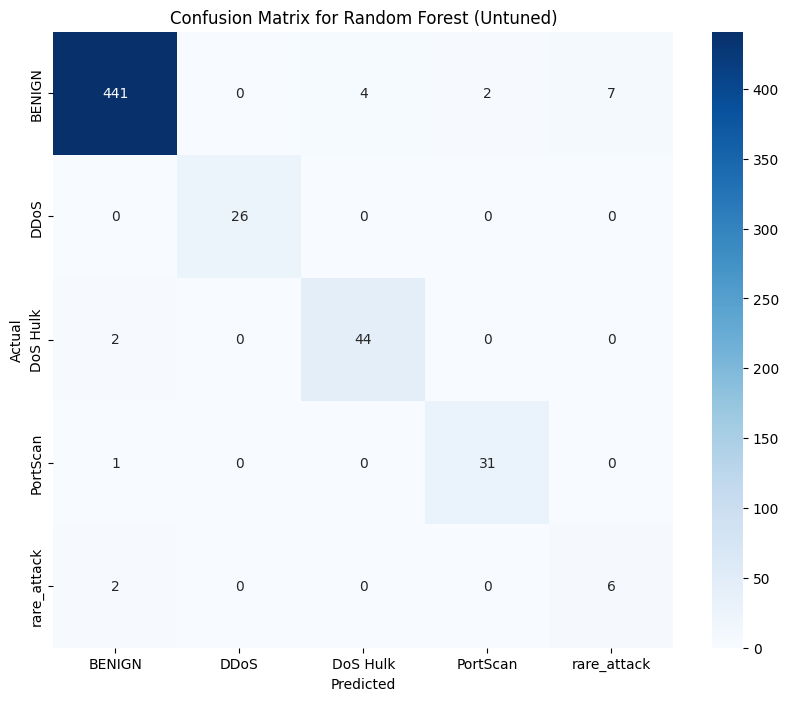

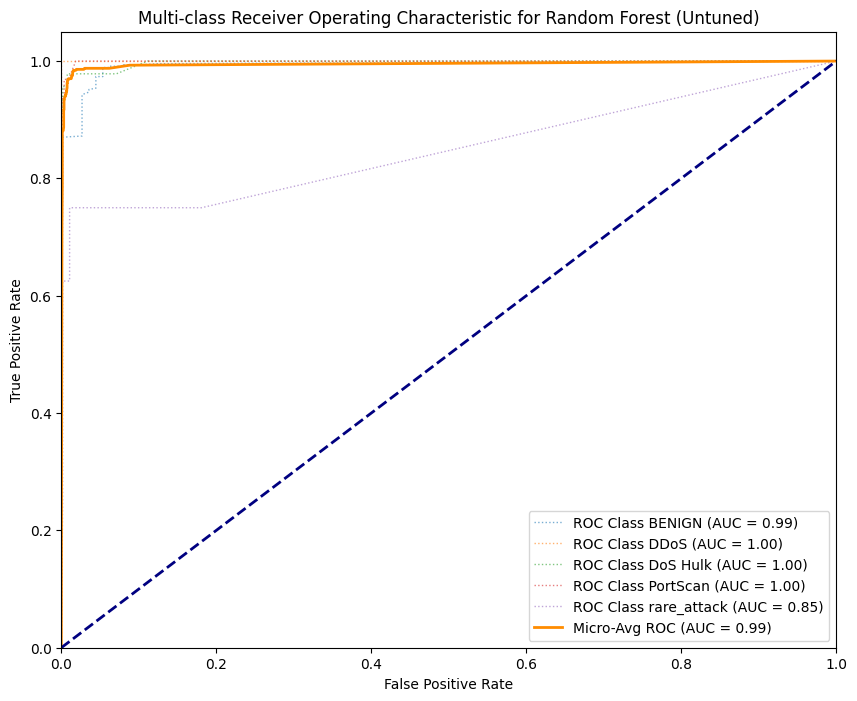

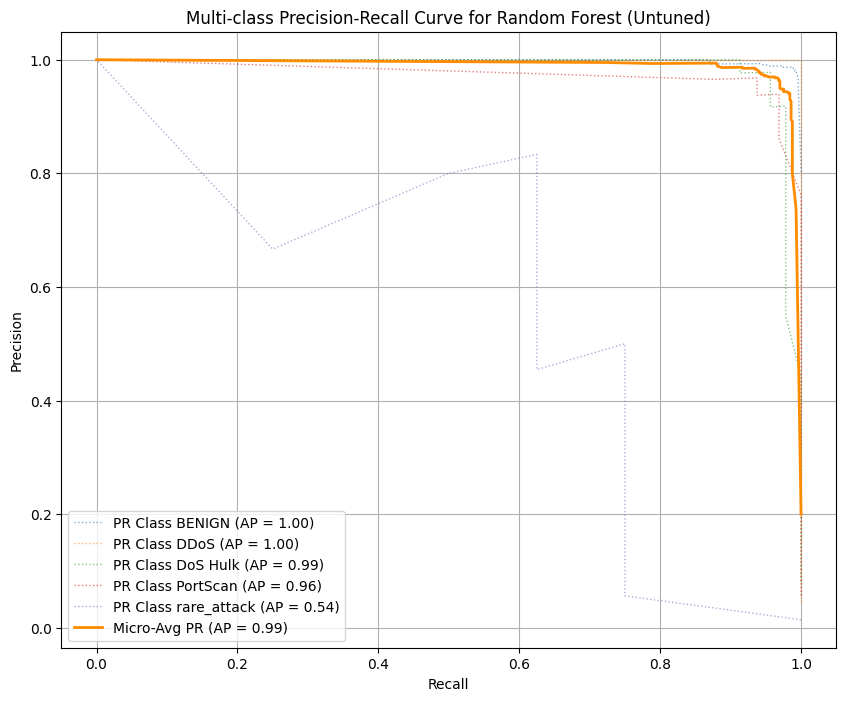

In [24]:
# Ensure final_label_encoder is available
final_label_encoder = None
try:
    # Use the name consistent with Code Block 1's saving
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Error: 'final_label_encoder.pkl' not found in {checkpoint_dir}. Please ensure previous stages were run and the encoder was saved.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")
    final_label_encoder = None

# Get class names from final_label_encoder for plotting and reports
class_names = []
num_classes = 0
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    num_classes = len(class_names)
else:
    if y_test is not None and len(np.unique(y_test)) > 0:
        unique_labels_in_test = sorted(np.unique(y_test))
        class_names = [f"Class {i}" for i in unique_labels_in_test]
        num_classes = len(unique_labels_in_test)
    else:
        print("Warning: y_test is None or empty. Cannot infer class names. Proceeding with default/empty class names.")
        class_names = [] # Ensure it's empty if cannot infer
        num_classes = 0 # Ensure num_classes is 0 if cannot infer
    print(f"Warning: final_label_encoder not available. Inferring class names from y_test and using generic names: {class_names}.")



# --- Select the best model based on F1-score ---
if 'model_performance' in locals() and model_performance:
    # Ensure model_performance keys are consistent with what's being loaded
    best_model_name = max(model_performance, key=model_performance.get)
    print(f"\nBest Model Selected: {best_model_name} with F1-score (Positive Class): {model_performance[best_model_name]:.4f}")

    # Checkpoint 1: Save the best_model_name
    best_model_name_path = os.path.join(checkpoint_dir, "best_model_name.pkl")
    joblib.dump(best_model_name, best_model_name_path)
    print(f"Checkpoint: Best model name saved to {best_model_name_path}")
else:
    best_model_name = "N/A"
    print("\nWarning: 'model_performance' not found or is empty. Cannot select best model.")


# --- Load the selected best model ---
final_model = None
if best_model_name != "N/A":
    try:
        # Use the exact filenames used for saving in Code Block 1
        if best_model_name == 'Baseline':
            final_model = joblib.load(os.path.join(checkpoint_dir, "dummy_model.pkl"))
        elif best_model_name == 'Logistic Regression (Untuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "logistic_regression_pipeline.pkl"))
        elif best_model_name == 'Logistic Regression (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_pipeline.pkl"))
        elif best_model_name == 'Random Forest (Untuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "random_forest_pipeline.pkl"))
        elif best_model_name == 'Random Forest (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_pipeline.pkl"))
        elif best_model_name == 'XGBoost (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_pipeline.pkl"))
        elif best_model_name == 'FFN':
            if X_test_processed is None or num_classes == 0:
                raise ValueError("X_test_processed or num_classes is required to instantiate FFN model but not found.")
            ffn_model_loaded = FFN(X_test_processed.shape[1], num_classes=num_classes).to(device)
            final_model_path = os.path.join(checkpoint_dir, "ffn_model_state_dict.pth")
            ffn_model_loaded.load_state_dict(torch.load(final_model_path, map_location=device))
            final_model = ffn_model_loaded
        elif best_model_name == 'LSTM':
            if X_test_processed is None or num_classes == 0:
                raise ValueError("X_test_processed or num_classes is required to instantiate LSTM model but not found.")
            # Ensure hidden_dim and num_layers match how your LSTM was saved in training
            lstm_model_loaded = LSTMNet(input_dim=X_test_processed.shape[1], hidden_dim=64, num_layers=1, num_classes=num_classes).to(device)
            final_model_path = os.path.join(checkpoint_dir, "lstm_model_state_dict.pth")
            lstm_model_loaded.load_state_dict(torch.load(final_model_path, map_location=device))
            final_model = lstm_model_loaded
        elif best_model_name == 'Stacking Classifier':
            final_model = joblib.load(os.path.join(checkpoint_dir, "stacked_classifier.pkl"))
        else:
            print(f"Error: Unrecognized best model name '{best_model_name}'. No model loaded.")

    except FileNotFoundError as e:
        print(f"Error loading {best_model_name}: {e}. Model file not found. Check checkpoint_dir and filenames.")
        final_model = None
    except ValueError as e:
        print(f"Error instantiating {best_model_name}: {e}.")
        final_model = None
    except Exception as e:
        print(f"An unexpected error occurred while loading {best_model_name}: {e}")
        final_model = None

if final_model is None:
    print(f"Could not load the selected best model: {best_model_name}. Skipping subsequent analysis.")

# Checkpoint 2: Save the final_model object
if final_model is not None:
    sanitized_model_name = best_model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
    final_model_filename = f"final_best_model_{sanitized_model_name}"
    final_model_path = os.path.join(checkpoint_dir, final_model_filename)

    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier)):
        try:
            joblib.dump(final_model, final_model_path + ".pkl")
            print(f"Checkpoint: Final best model saved to {final_model_path}.pkl")
        except Exception as e:
            print(f"Error saving Scikit-learn type model: {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        try:
            torch.save(final_model.state_dict(), final_model_path + "_state_dict.pth")
            print(f"Checkpoint: Final best PyTorch model state_dict saved to {final_model_path}_state_dict.pth")
        except Exception as e:
            print(f"Error saving PyTorch model state_dict: {e}")
    else:
        print(f"Warning: Final model type '{type(final_model).__name__}' not recognized for explicit checkpointing. Skipping final model save.")
else:
    print("Skipping final model checkpointing as final_model is None.")


# --- Determine final_y_pred and final_y_prob for the selected best_model ---
final_y_pred = None
final_y_prob = None

if final_model is not None and X_test_processed is not None and y_test is not None:
    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier)):
        try:
            final_y_pred = final_model.predict(X_test_processed)
            if hasattr(final_model, 'predict_proba'):
                final_y_prob = final_model.predict_proba(X_test_processed)
            else:
                print(f"Warning: Model type {type(final_model).__name__} does not support predict_proba. ROC/PR curves will be skipped.")
        except Exception as e:
            print(f"Error making predictions with Scikit-learn type model '{best_model_name}': {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        try:
            final_model.eval()
            with torch.no_grad():
                X_test_tensor_final = torch.tensor(X_test_processed, dtype=torch.float32).to(device)

                if isinstance(final_model, LSTMNet) and X_test_tensor_final.ndim == 2:
                    X_test_tensor_final = X_test_tensor_final.unsqueeze(1)

                y_pred_logits_final = final_model(X_test_tensor_final).cpu()
                final_y_prob = torch.softmax(y_pred_logits_final, dim=1).numpy()
                final_y_pred = np.argmax(final_y_prob, axis=1)
        except Exception as e:
            print(f"Error making predictions with PyTorch model '{best_model_name}': {e}")
    else:
        print(f"Warning: Final model type {type(final_model).__name__} not recognized for final prediction and plotting.")
else:
    print("Cannot generate final predictions/probabilities: final_model, X_test_processed, or y_test is missing.")

# Checkpoint 3: Save final predictions and probabilities
if final_y_pred is not None:
    final_y_pred_path = os.path.join(checkpoint_dir, "final_y_pred.npy")
    np.save(final_y_pred_path, final_y_pred)
    print(f"Checkpoint: Final predictions saved to {final_y_pred_path}")

if final_y_prob is not None:
    final_y_prob_path = os.path.join(checkpoint_dir, "final_y_prob.npy")
    np.save(final_y_prob_path, final_y_prob)
    print(f"Checkpoint: Final probabilities saved to {final_y_prob_path}")


# --- Proceed with Final Model Results Plotting ---

print(f"\n--- Final Model Results for {best_model_name} ---")

# Robust check for plotting prerequisites: ensure predictions, true labels, and class names are available
if final_y_pred is not None and y_test is not None and len(class_names) > 0:
    print("Classification Report:")
    print(classification_report(y_test, final_y_pred, target_names=class_names, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, final_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if final_y_prob is not None and final_y_prob.shape[1] > 1: # Ensure it's not a binary probability for one class
        # ROC Curve (Multi-class: One-vs-Rest or Averaged)
        plt.figure(figsize=(10, 8))
        lb_roc = LabelBinarizer()
        y_test_binarized_final = lb_roc.fit_transform(y_test)
        n_classes = y_test_binarized_final.shape[1]

        for i in range(n_classes):
            # Ensure final_y_prob has enough columns for this class
            if final_y_prob.shape[1] > i:
                fpr, tpr, _ = roc_curve(y_test_binarized_final[:, i], final_y_prob[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=1, linestyle=':', alpha=0.6,
                                     label=f'ROC Class {class_names[i]} (AUC = {roc_auc:.2f})')
            else:
                print(f"Warning: Probability data for class '{class_names[i]}' (index {i}) not found in final_y_prob. Skipping individual ROC for this class.")

        fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized_final.ravel(), final_y_prob.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        plt.plot(fpr_micro, tpr_micro, lw=2, color='darkorange',
                                 label=f'Micro-Avg ROC (AUC = {roc_auc_micro:.2f})')

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multi-class Receiver Operating Characteristic for {best_model_name}')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall Curve (Multi-class: One-vs-Rest or Averaged)
        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            if final_y_prob.shape[1] > i:
                precision, recall, _ = precision_recall_curve(y_test_binarized_final[:, i], final_y_prob[:, i])
                aps = average_precision_score(y_test_binarized_final[:, i], final_y_prob[:, i])
                plt.plot(recall, precision, lw=1, linestyle=':', alpha=0.6,
                                     label=f'PR Class {class_names[i]} (AP = {aps:.2f})')
            else:
                print(f"Warning: Probability data for class '{class_names[i]}' (index {i}) not found in final_y_prob. Skipping individual PR for this class.")

        precision_micro, recall_micro, _ = precision_recall_curve(y_test_binarized_final.ravel(), final_y_prob.ravel())
        ap_micro = average_precision_score(y_test_binarized_final, final_y_prob, average='micro')
        plt.plot(recall_micro, precision_micro, color='darkorange', lw=2,
                                 label=f'Micro-Avg PR (AP = {ap_micro:.2f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Multi-class Precision-Recall Curve for {best_model_name}')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()
    else:
        print("\nCould not generate ROC and PR curves as probability predictions are not available for the final model or it's a binary probability (only one column).")
else:
    print("Final model prediction failed or plotting skipped due to missing data (final_y_pred, y_test, or class_names is empty).")

## 9. Model Interpretation
This section focuses on Model Interpretability, specifically using SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to understand how the selected best model makes its predictions.

Loaded final_label_encoder for current stage.

--- Model Interpretation ---
Interpreting a subset of 200 samples from the test set.
Number of classes detected for interpretation: 5

--- SHAP Interpretation for Random Forest (Untuned) (Tree-based) ---
SHAP values computed for single output/binary classification.


<Figure size 1200x800 with 0 Axes>

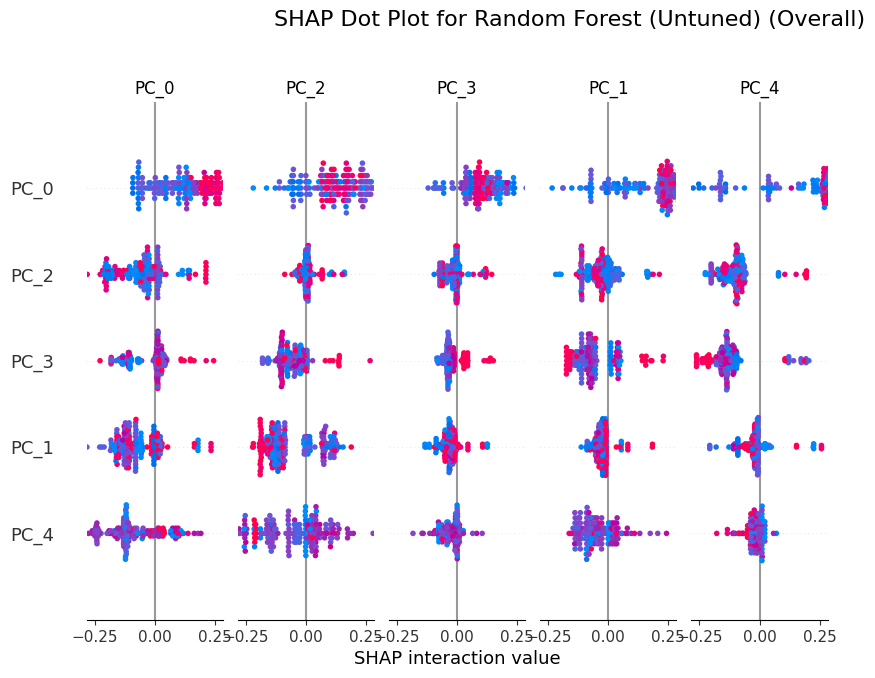

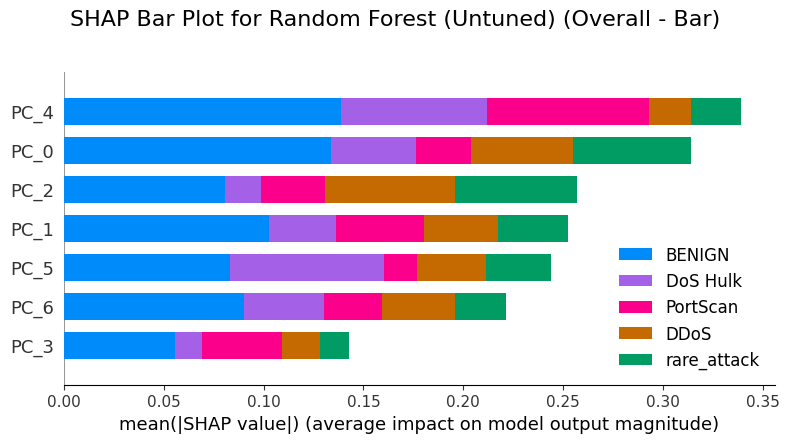

Note: SHAP values are computed on PCA components. Interpreting these components requires understanding their original feature contributions from the PCA loading matrix.
--- End SHAP Explanations ---


In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from lime import lime_tabular
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, VotingClassifier # Added VotingClassifier for completeness
from sklearn.dummy import DummyClassifier
import os
import joblib
import pickle
from tqdm import tqdm # For progress bars

# --- 0. Robustly Load final_label_encoder and Define Class Names ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_label_encoder.pkl' not found in {checkpoint_dir}. "
          "Attempting to infer class names from y_test.")
except Exception as e:
    print(f"Error loading final_label_encoder: {e}. Attempting to infer class names from y_test.")

class_names = []
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
elif 'y_test' in locals() and y_test is not None and len(y_test) > 0:
    # Infer distinct classes and sort them to ensure consistent naming
    unique_classes = sorted(np.unique(y_test))
    class_names = [f"Class {i}" for i in unique_classes]
    print(f"Inferred class names from y_test: {class_names}")
else:
    print("Error: 'final_label_encoder' not available and y_test is empty or not found. Cannot determine class names.")
    print("Interpretation plots might lack meaningful class labels.")
    # Fallback to generic names if absolutely no info
    class_names = [f"Class {i}" for i in range(2)] # Default to 2 classes as a last resort for plotting


print("\n--- Model Interpretation ---")

# --- 1. Pre-computation and Data Preparation ---
if 'final_model' in locals() and final_model is not None and \
   'X_test_processed' in locals() and X_test_processed is not None and len(X_test_processed) > 0 and \
   'y_test' in locals() and y_test is not None and len(y_test) > 0:

    # Determine the actual model to interpret from the pipeline or as a standalone model
    model_for_shap = final_model.named_steps['model'] if isinstance(final_model, Pipeline) else final_model

    # Use a subset for faster computation of interpretation methods
    # Convert to NumPy arrays for consistent positional indexing
    X_test_processed_np = X_test_processed.values if hasattr(X_test_processed, 'values') else X_test_processed
    y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

    subset_size = min(200, len(X_test_processed_np)) # Increased subset size for potentially better representation
    np.random.seed(SEED)
    indices = np.random.choice(len(X_test_processed_np), subset_size, replace=False)

    X_test_processed_for_shap = X_test_processed_np[indices]
    y_test_subset_for_shap = y_test_np[indices]

    # Feature names (using PCA components as a default)
    feature_names = [f'PC_{i}' for i in range(X_test_processed_for_shap.shape[1])]
    # If original feature names are available from a preprocessor, use them:
    # try:
    #     if hasattr(final_model.named_steps['preprocessor'], 'get_feature_names_out'):
    #         feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
    #     elif hasattr(X_test_processed, 'columns'):
    #         feature_names = X_test_processed.columns.tolist()
    # except Exception:
    #     pass # Fallback to PC_i names if extraction fails

    print(f"Interpreting a subset of {subset_size} samples from the test set.")
    print(f"Number of classes detected for interpretation: {len(class_names)}")


    # --- 2. Helper Functions for Plotting ---
    def plot_shap_summary(shap_values, data, feature_names, title_suffix="", plot_type="dot"):
        plt.figure(figsize=(12, 8))
        if plot_type == "dot":
            shap.summary_plot(shap_values, data, feature_names=feature_names, show=False, class_names=class_names)
        elif plot_type == "bar":
            shap.summary_plot(shap_values, data, plot_type="bar", feature_names=feature_names, show=False, class_names=class_names)

        plt.suptitle(f'SHAP {plot_type.capitalize()} Plot for {best_model_name} {title_suffix}', fontsize=16, y=1.02, ha='center')
        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.show()

    # --- 3. Model-Specific Interpretation Blocks ---

    # --- Tree-based Models (XGBoost, RandomForest) ---
    if isinstance(model_for_shap, (xgb.XGBClassifier, RandomForestClassifier)):
        print(f"\n--- SHAP Interpretation for {best_model_name} (Tree-based) ---")
        try:
            explainer = shap.TreeExplainer(model_for_shap)
            shap_values = explainer.shap_values(X_test_processed_for_shap)

            if isinstance(shap_values, list) and len(shap_values) > 1: # Multi-class output
                print(f"SHAP values computed for {len(shap_values)} classes.")
                # Overall summary plot (mean absolute SHAP values across all classes)
                plot_shap_summary(shap_values, X_test_processed_for_shap, feature_names, "(Overall)")
                plot_shap_summary(shap_values, X_test_processed_for_shap, feature_names, "(Overall - Bar)", plot_type="bar")

                # Individual class SHAP plots
                for i, class_shap_values in enumerate(shap_values):
                    if i < len(class_names):
                        class_title = f"({class_names[i]})"
                        plot_shap_summary(class_shap_values, X_test_processed_for_shap, feature_names, class_title)
                    else:
                        print(f"Warning: No class name for index {i}. Plotting for generic Class {i}.")
                        plot_shap_summary(class_shap_values, X_test_processed_for_shap, feature_names, f"(Class {i})")

            else: # Binary classification or single output
                print("SHAP values computed for single output/binary classification.")
                plot_shap_summary(shap_values, X_test_processed_for_shap, feature_names, "(Overall)")
                plot_shap_summary(shap_values, X_test_processed_for_shap, feature_names, "(Overall - Bar)", plot_type="bar")

        except Exception as e:
            print(f"Error during SHAP interpretation for Tree-based models: {e}")

        print("Note: SHAP values are computed on PCA components. Interpreting these components requires understanding their original feature contributions from the PCA loading matrix.")
        print("--- End SHAP Explanations ---")

    # --- Logistic Regression ---
    elif isinstance(model_for_shap, LogisticRegression):
        print(f"\n--- Feature Importance for {best_model_name} (Logistic Regression) ---")
        try:
            # Permutation Importance
            print("Calculating Permutation Importance...")
            result = permutation_importance(model_for_shap, X_test_processed_for_shap, y_test_subset_for_shap,
                                            n_repeats=10, random_state=SEED, n_jobs=-1)
            sorted_idx = result.importances_mean.argsort()

            plt.figure(figsize=(10, 8))
            plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
            plt.title(f"Permutation Importance ({best_model_name})")
            plt.tight_layout()
            plt.show()

            # Coefficients (if not already handled by PCA/scaling, might be less directly interpretable)
            print("\nCoefficients (Scaled, if applicable):")
            if hasattr(model_for_shap, 'coef_') and model_for_shap.coef_.size > 0:
                if model_for_shap.coef_.ndim == 1: # Binary
                    coefs = model_for_shap.coef_
                    for i, coef in enumerate(coefs):
                        print(f"{feature_names[i]}: {coef:.4f}")
                else: # Multi-class
                    for i, class_coefs in enumerate(model_for_shap.coef_):
                        if i < len(class_names):
                            print(f"\n--- Coefficients for Class: {class_names[i]} ---")
                        else:
                             print(f"\n--- Coefficients for Class: {i} (Unnamed) ---")
                        for j, coef in enumerate(class_coefs):
                            print(f"{feature_names[j]}: {coef:.4f}")
            else:
                print("Coefficients not available or model not fitted properly.")

            # Optional: SHAP KernelExplainer for LR for consistency
            # if 'X_train_processed' in locals() and len(X_train_processed) > 0:
            #     print("\n--- SHAP (KernelExplainer) for Logistic Regression ---")
            #     X_train_processed_np_lime = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
            #     background_data_kernel_lr = shap.utils.sample(X_train_processed_np_lime, min(100, len(X_train_processed_np_lime)), random_state=SEED)
            #     explainer_kernel_lr = shap.KernelExplainer(model_for_shap.predict_proba, background_data_kernel_lr)
            #     shap_values_kernel_lr = explainer_kernel_lr.shap_values(X_test_processed_for_shap)
            #     plot_shap_summary(shap_values_kernel_lr, X_test_processed_for_shap, feature_names, "(KernelExplainer)")
            # else:
            #     print("Warning: X_train_processed not available for KernelExplainer for Logistic Regression.")

        except Exception as e:
            print(f"Error during interpretation for Logistic Regression: {e}")

    # --- Neural Networks (FFN, LSTMNet) ---
    elif isinstance(model_for_shap, (FFN, LSTMNet)):
        print(f"\n--- Advanced Interpretation for {best_model_name} (Neural Networks) using SHAP and LIME ---")

        if 'device' not in locals():
            print("Error: 'device' (for PyTorch models) is not defined. Skipping NN interpretation.")
        else:
            # Prepare background data for SHAP DeepExplainer
            background_data = torch.tensor([], dtype=torch.float32).to(device)
            if 'X_train_processed' in locals() and len(X_train_processed) > 0:
                X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
                # Use a more intelligent sampling for background data, e.g., k-means
                try:
                    background_data_sampler = shap.kmeans(X_train_processed_np, min(100, X_train_processed_np.shape[0]))
                    background_data = torch.tensor(background_data_sampler.data, dtype=torch.float32).to(device)
                except Exception as e:
                    print(f"Warning: Could not use k-means sampling for SHAP background data: {e}. Falling back to random sampling.")
                    background_data_indices = np.random.choice(X_train_processed_np.shape[0], min(100, X_train_processed_np.shape[0]), replace=False)
                    background_data = torch.tensor(X_train_processed_np[background_data_indices], dtype=torch.float32).to(device)
            else:
                print("Warning: X_train_processed not found or is empty. Cannot generate SHAP background data for Neural Networks.")

            if background_data.shape[0] > 0:
                try:
                    # SHAP DeepExplainer
                    model_for_shap.eval() # Set model to evaluation mode
                    if isinstance(model_for_shap, LSTMNet):
                        explainer_nn = shap.DeepExplainer(model_for_shap, background_data.unsqueeze(-1))
                        shap_values_nn = explainer_nn.shap_values(torch.tensor(X_test_processed_for_shap, dtype=torch.float32).unsqueeze(-1).to(device))
                    else: # FFN
                        explainer_nn = shap.DeepExplainer(model_for_shap, background_data)
                        shap_values_nn = explainer_nn.shap_values(torch.tensor(X_test_processed_for_shap, dtype=torch.float32).to(device))

                    plot_shap_summary(shap_values_nn, X_test_processed_for_shap, feature_names, "(DeepExplainer)")

                    print("\nNote: SHAP values for Neural Networks provide insights into feature contributions.")
                    print("Other advanced interpretation techniques include LIME for local explanations, or visualizing activations.")

                except Exception as e:
                    print(f"Error during SHAP DeepExplainer for Neural Networks: {e}")

                # LIME Interpretation
                print(f"\n--- LIME Interpretation for {best_model_name} (Neural Networks) ---")

                def predict_proba_nn(data):
                    model_for_shap.eval() # Set model to evaluation mode
                    with torch.no_grad():
                        if isinstance(model_for_shap, LSTMNet):
                            tensor_data = torch.tensor(data, dtype=torch.float32).unsqueeze(-1).to(device)
                        else: # FFN
                            tensor_data = torch.tensor(data, dtype=torch.float32).to(device)
                        logits = model_for_shap(tensor_data)
                        probs = torch.softmax(logits, dim=1).cpu().numpy()
                        return probs

                if 'X_train_processed' in locals() and len(X_train_processed) > 0:
                    X_train_processed_np_lime = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
                    explainer_lime = lime_tabular.LimeTabularExplainer(
                        training_data=X_train_processed_np_lime, # Use full training data for training_data for LIME
                        feature_names=feature_names,
                        class_names=class_names,
                        mode='classification'
                    )

                    num_lime_explanations = min(5, len(X_test_processed_for_shap)) # Explain a few instances
                    np.random.seed(SEED)
                    lime_indices = np.random.choice(len(X_test_processed_for_shap), num_lime_explanations, replace=False)

                    for i, idx in enumerate(lime_indices):
                        data_point_to_explain = X_test_processed_for_shap[idx]
                        true_label = y_test_subset_for_shap[idx]
                        predicted_probs_for_instance = predict_proba_nn(data_point_to_explain.reshape(1, -1))
                        predicted_label = np.argmax(predicted_probs_for_instance, axis=1)[0]

                        print(f"\nExplaining instance {idx+1}/{num_lime_explanations}: True Label = {class_names[true_label]}, Predicted Label = {class_names[predicted_label]}")

                        try:
                            explanation = explainer_lime.explain_instance(
                                data_row=data_point_to_explain,
                                predict_fn=predict_proba_nn,
                                num_features=min(10, len(feature_names)), # Explain top features, max 10
                                top_labels=len(class_names) # Show explanations for all classes
                            )

                            explanation.as_pyplot_figure(label=predicted_label) # Focus on the predicted label
                            plt.title(f"LIME Explanation for Instance {idx} (True: {class_names[true_label]}, Pred: {class_names[predicted_label]})")
                            plt.tight_layout()
                            plt.show()

                            print("LIME Explanation (Feature Weights):")
                            for class_idx in range(len(class_names)):
                                if predicted_probs_for_instance[0][class_idx] > 0.05: # Only show for relevant classes
                                    print(f"  For class '{class_names[class_idx]}':")
                                    print(explanation.as_list(label=class_idx))
                            # print(explanation.as_list()) # This prints for the default class
                        except Exception as e:
                            print(f"Error during LIME explanation for instance {idx}: {e}")

                    print("\nNote: LIME provides local explanations, showing which features are important for a *single prediction*.")
                else:
                    print("Warning: X_train_processed not found or is empty. Skipping LIME interpretation for Neural Networks.")
            else:
                print("Skipping SHAP and LIME for Neural Networks due to missing background data.")

    # --- StackingClassifier or VotingClassifier ---
    elif isinstance(model_for_shap, (StackingClassifier, VotingClassifier)):
        print(f"\n--- Model-Agnostic Interpretation for {best_model_name} (KernelExplainer/LIME) ---")

        def predict_proba_model(data):
            # Ensure the input data to predict_proba is correctly processed if the stacking classifier expects it
            return model_for_shap.predict_proba(data)

        # KernelExplainer requires a background dataset.
        background_data_kernel = np.array([])
        if 'X_train_res' in locals() and len(X_train_res) > 0:
            X_train_res_np = X_train_res.values if hasattr(X_train_res, 'values') else X_train_res
            background_data_kernel = shap.utils.sample(X_train_res_np, min(200, len(X_train_res_np)), random_state=SEED) # Increased sample size
        elif 'X_train_processed' in locals() and len(X_train_processed) > 0:
            X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
            background_data_kernel = shap.utils.sample(X_train_processed_np, min(200, len(X_train_processed_np)), random_state=SEED)
        else:
            print("Warning: Neither X_train_res nor X_train_processed found or are empty. Cannot generate SHAP background data for Model-Agnostic Explainers.")

        if background_data_kernel.shape[0] > 0:
            try:
                print("Calculating SHAP values using KernelExplainer (this may take a while)...")
                explainer_kernel = shap.KernelExplainer(predict_proba_model, background_data_kernel)
                # Calculate SHAP values for the subset of the test data
                # Using tqdm for progress for computationally intensive KernelExplainer
                shap_values_kernel = explainer_kernel.shap_values(X_test_processed_for_shap) #, n_jobs=-1 is not supported by KernelExplainer directly

                plot_shap_summary(shap_values_kernel, X_test_processed_for_shap, feature_names, "(KernelExplainer)")
                plot_shap_summary(shap_values_kernel, X_test_processed_for_shap, feature_names, "(KernelExplainer - Bar)", plot_type="bar")

                print("\nNote: KernelExplainer is more computationally intensive than TreeExplainer or DeepExplainer.")
                print("It provides model-agnostic explanations for any scikit-learn compatible model.")
            except Exception as e:
                print(f"Error during SHAP KernelExplainer for Stacking/Voting Classifier: {e}")
        else:
            print("Skipping SHAP KernelExplainer due to missing background data.")

        # LIME for Stacking/Voting Classifiers (can reuse predict_proba_model)
        if 'X_train_processed' in locals() and len(X_train_processed) > 0:
            print(f"\n--- LIME Interpretation for {best_model_name} (Model-Agnostic) ---")
            X_train_processed_np_lime = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
            explainer_lime_stacked = lime_tabular.LimeTabularExplainer(
                training_data=X_train_processed_np_lime,
                feature_names=feature_names,
                class_names=class_names,
                mode='classification'
            )

            num_lime_explanations = min(3, len(X_test_processed_for_shap))
            np.random.seed(SEED)
            lime_indices = np.random.choice(len(X_test_processed_for_shap), num_lime_explanations, replace=False)

            for i, idx in enumerate(lime_indices):
                data_point_to_explain = X_test_processed_for_shap[idx]
                true_label = y_test_subset_for_shap[idx]
                predicted_probs_for_instance = predict_proba_model(data_point_to_explain.reshape(1, -1))
                predicted_label = np.argmax(predicted_probs_for_instance, axis=1)[0]

                print(f"\nExplaining instance {idx+1}/{num_lime_explanations}: True Label = {class_names[true_label]}, Predicted Label = {class_names[predicted_label]}")

                try:
                    explanation = explainer_lime_stacked.explain_instance(
                        data_row=data_point_to_explain,
                        predict_fn=predict_proba_model,
                        num_features=min(10, len(feature_names)),
                        top_labels=len(class_names)
                    )

                    explanation.as_pyplot_figure(label=predicted_label)
                    plt.title(f"LIME Explanation for Instance {idx} (True: {class_names[true_label]}, Pred: {class_names[predicted_label]})")
                    plt.tight_layout()
                    plt.show()

                    print("LIME Explanation (Feature Weights):")
                    for class_idx in range(len(class_names)):
                        if predicted_probs_for_instance[0][class_idx] > 0.05:
                            print(f"  For class '{class_names[class_idx]}':")
                            print(explanation.as_list(label=class_idx))
                except Exception as e:
                    print(f"Error during LIME explanation for instance {idx}: {e}")
        else:
            print("Warning: X_train_processed not found or is empty. Skipping LIME interpretation for Stacking/Voting Classifiers.")


        # Optional: Interpret individual base estimators (more complex, but valuable)
        # print("\n--- Interpreting Base Estimators of StackingClassifier ---")
        # if isinstance(model_for_shap, StackingClassifier):
        #     for name, estimator in model_for_shap.named_estimators_.items():
        #         print(f"\n--- Interpretation for Base Estimator: {name} ({type(estimator).__name__}) ---")
        #         # You'd need to re-run appropriate interpretation for each estimator
        #         # This would likely involve passing the *original* (pre-stacking) data if that's what base estimators see
        #         # For simplicity, this is often omitted in a general pipeline, but can be powerful.


    # --- DummyClassifier ---
    elif isinstance(model_for_shap, DummyClassifier):
        print("\nInterpretation for Baseline Model (DummyClassifier) is straightforward as it simply predicts the most frequent class or a constant value.")
        if hasattr(model_for_shap, 'strategy'):
            print(f"Strategy: {model_for_shap.strategy}")
        if hasattr(model_for_shap, 'constant_'):
            print(f"Constant prediction: {model_for_shap.constant_}")
        if hasattr(model_for_shap, 'n_outputs_'):
            print(f"Number of outputs: {model_for_shap.n_outputs_}")
        if hasattr(model_for_shap, 'classes_'):
            print(f"Classes: {model_for_shap.classes_}")

    # --- Unhandled Model Types ---
    else:
        print(f"\nModel interpretation methods are not explicitly defined for the selected model type ({type(model_for_shap).__name__}). Consider adding relevant interpretation techniques.")

else:
    print("\nSkipping model interpretation. Ensure 'final_model', 'X_test_processed', and 'y_test' are defined and not empty.")
    if 'final_model' not in locals() or final_model is None:
        print("- 'final_model' is not available.")
    if 'X_test_processed' not in locals() or X_test_processed is None or len(X_test_processed) == 0:
        print("- 'X_test_processed' is missing or empty.")
    if 'y_test' not in locals() or y_test is None or len(y_test) == 0:
        print("- 'y_test' is missing or empty.")

## 10. Save the Best ML Model
This section saves the best-performing machine learning model, its name, and the label encoder used for the target variable to the specified checkpoint_dir. It intelligently handles saving both PyTorch models (saving state_dict) and scikit-learn models (using joblib.dump) to ensure the entire trained pipeline can be persistently stored and reloaded for future use.

In [28]:
import joblib
import os
import torch
import pickle # Import pickle for LabelEncoder

print("\n--- Saving the Best Model (Multi-class) ---")

# --- 1. Robustly Check for Essential Variables ---
# Assume checkpoint_dir is defined globally or passed as an argument.
# If not, you might want to define a default or raise an error.
if 'checkpoint_dir' not in locals() or checkpoint_dir is None:
    print("Error: 'checkpoint_dir' is not defined. Cannot save model.")
    # You might want to set a default or exit here:
    # checkpoint_dir = "./saved_models"
    # os.makedirs(checkpoint_dir, exist_ok=True)
    # print(f"Using default checkpoint_dir: {checkpoint_dir}")
    # return # Or exit, depending on desired behavior
    exit() # Exiting as saving is critical and requires a directory

if 'best_model_name' not in locals() or best_model_name is None:
    print("Warning: 'best_model_name' is not defined. Using 'unnamed_model'.")
    best_model_name = "unnamed_model"

# --- 2. Check if final_model exists ---
if 'final_model' in locals() and final_model is not None:
    # Use a clear naming convention for multi-class classification models
    model_filename_base = f'best_multiclass_model_{best_model_name.replace(" ", "_").lower()}'

    # Construct the full path within the designated checkpoint directory
    model_path = os.path.join(checkpoint_dir, model_filename_base)

    try:
        if isinstance(final_model, (torch.nn.Module)):
            # For PyTorch models, save the state dictionary
            torch.save(final_model.state_dict(), f'{model_path}_state_dict.pth')
            print(f"PyTorch multi-class model state dictionary saved to {model_path}_state_dict.pth")
        else: # For scikit-learn pipelines/models (including XGBoost, RandomForest, LogisticRegression, Stacking)
            joblib.dump(final_model, f'{model_path}.joblib')
            print(f"Scikit-learn multi-class model saved as {model_path}.joblib (includes pipeline if applicable)")

        # --- 3. Save best_model_name metadata ---
        # This file indicates which type of model (PyTorch, sklearn) was saved
        best_model_name_meta_path = os.path.join(checkpoint_dir, "best_multiclass_model_type.pkl")
        with open(best_model_name_meta_path, "wb") as f:
            pickle.dump(best_model_name, f)
        print(f"Best model name '{best_model_name}' saved to {best_model_name_meta_path}")

        # --- 4. Save the LabelEncoder (CRUCIAL for multi-class) ---
        if 'final_label_encoder' in locals() and final_label_encoder is not None:
            label_encoder_path = os.path.join(checkpoint_dir, "final_multiclass_label_encoder.pkl")
            try:
                with open(label_encoder_path, "wb") as f:
                    pickle.dump(final_label_encoder, f)
                print(f"Final multi-class LabelEncoder saved to {label_encoder_path}")
            except Exception as e:
                print(f"Error saving LabelEncoder to {label_encoder_path}: {e}")
        else:
            print("Warning: 'final_label_encoder' not found. It is highly recommended to save it for consistent multi-class inference.")

    except Exception as e:
        print(f"An error occurred while saving the model: {e}")
else:
    print("No 'final_model' available to save. Please ensure 'final_model' is set from previous training steps.")

print("\n--- End of Notebook ---")


--- Saving the Best Model (Multi-class) ---
Scikit-learn multi-class model saved as ./model_checkpoints/best_multiclass_model_random_forest_(untuned).joblib (includes pipeline if applicable)
Best model name 'Random Forest (Untuned)' saved to ./model_checkpoints/best_multiclass_model_type.pkl
Final multi-class LabelEncoder saved to ./model_checkpoints/final_multiclass_label_encoder.pkl

--- End of Notebook ---


## 11. Implementation
This section defines a Python function 'predict_attack_type' that enables real-time inference and explanation for a deployed machine learning model. It loads a previously trained model (either scikit-learn or PyTorch), a preprocessor, and a label encoder, then takes a new raw observation, preprocesses it, makes a binary attack prediction with certainty, and generates a SHAP waterfall plot to visually explain the key features influencing that specific prediction.

In [30]:
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
import joblib
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# --- Placeholder classes for demonstration; Replace with your actual model definitions ---
# Ensure these classes are accessible in the environment where predict_attack_type is called.
# Ideally, these would be imported from a separate models.py file.
class FFN(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FFN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class LSTMNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        # For our PCA components, input_dim would be 1 and sequence_length is num_components
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Get output from the last time step
        return out


def predict_attack_type(observation_raw, best_model_name_for_loading, device_for_pred='cpu', checkpoint_dir="./model_checkpoints"):
    """
    Predicts the type of network attack (multi-class classification) using a trained model
    and provides SHAP explanations.

    Args:
        observation_raw (dict or pd.DataFrame or pd.Series): A single network flow's data.
        best_model_name_for_loading (str): The name of the best model (e.g., "XGBoost Classifier")
                                           used to construct the filename.
        device_for_pred (str): Device to run PyTorch models on ('cpu' or 'cuda').
        checkpoint_dir (str): Directory where models, preprocessor, and label encoder are saved.

    Returns:
        tuple:
            - str: Predicted attack type (e.g., 'Normal', 'DoS', 'rare_attack').
            - float: Certainty (probability) of the predicted class, as a percentage.
            - dict: A dictionary containing the SHAP explanation data (values, base_value, data, feature_names)
                    for the predicted class, or None if SHAP failed.
    """
    model = None
    preprocessor = None
    label_encoder = None
    background_data_for_shap = None
    shap_explanation_data = None # To store SHAP components
    feature_names_original = None # To store original feature names for validation

    # --- Path Definitions (centralized and multi-class specific) ---
    model_base_filename = f'final_best_multiclass_model_{best_model_name_for_loading.replace(" ", "_").lower()}'
    model_pkl_path = os.path.join(checkpoint_dir, f'{model_base_filename}.pkl') # For scikit-learn models
    model_pth_path = os.path.join(checkpoint_dir, f'{model_base_filename}_state_dict.pth') # For PyTorch models
    preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor.joblib') # Assumes preprocessor is always named this
    label_encoder_path = os.path.join(checkpoint_dir, 'final_label_encoder.pkl') # Multi-class specific name
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background.joblib')
    original_feature_names_path = os.path.join(checkpoint_dir, 'original_feature_names.pkl') # Consistent with binary

    # --- Load Required Components ---
    try:
        # Load the preprocessor first to get feature details if needed
        if os.path.exists(preprocessor_path):
            with open(preprocessor_path, "rb") as file:
                preprocessor = joblib.load(file)
            print(f"Loaded preprocessor from {preprocessor_path}")
        else:
            raise FileNotFoundError(f"Preprocessor not found at {preprocessor_path}. Cannot proceed.")

        # Load original feature names for input validation
        if os.path.exists(original_feature_names_path):
            with open(original_feature_names_path, "rb") as file:
                feature_names_original = pickle.load(file)
            print(f"Loaded original feature names from {original_feature_names_path}")
        else:
            print(f"Warning: Original feature names not found at {original_feature_names_path}. Input validation may be less strict.")

        # Load label encoder (crucial for num_classes and inverse_transform)
        if os.path.exists(label_encoder_path):
            with open(label_encoder_path, "rb") as file:
                label_encoder = pickle.load(file)
            print(f"Loaded label encoder from {label_encoder_path}")
            class_names = label_encoder.classes_
            num_classes = len(class_names)
        else:
            raise FileNotFoundError(f"Label encoder not found at {label_encoder_path}. Cannot determine number of classes.")

        # Load the trained model
        if os.path.exists(model_pkl_path):
            model = joblib.load(model_pkl_path)
            print(f"Loaded scikit-learn model from {model_pkl_path}")
        elif os.path.exists(model_pth_path):
            # For PyTorch models, need to instantiate the class first
            input_dim = None
            if hasattr(preprocessor, 'n_components_'): # For PCA directly
                input_dim = preprocessor.n_components_
            elif isinstance(preprocessor, Pipeline) and 'pca' in preprocessor.named_steps and hasattr(preprocessor.named_steps['pca'], 'n_components_'):
                input_dim = preprocessor.named_steps['pca'].n_components_
            elif hasattr(preprocessor, 'get_feature_names_out'): # For ColumnTransformer or other complex preprocessors
                try:
                    dummy_data = pd.DataFrame(0, index=[0], columns=feature_names_original if feature_names_original is not None else ['dummy_col'])
                    input_dim = preprocessor.transform(dummy_data).shape[1]
                    print(f"Inferred input_dim from preprocessor: {input_dim}")
                except Exception as e:
                    print(f"Could not infer input_dim from preprocessor for PyTorch model: {e}")

            if input_dim is None:
                raise ValueError("Could not determine input_dim for PyTorch model. Ensure preprocessor is compatible or input_dim is explicitly saved/passed during training.")

            if "ffn" in best_model_name_for_loading.lower():
                model = FFN(input_dim=input_dim, num_classes=num_classes).to(device_for_pred)
            elif "lstmnet" in best_model_name_for_loading.lower():
                # hidden_dim and num_layers should be saved/loaded for robustness
                # Assuming 64 hidden, 2 layers as common defaults if not saved explicitly
                model = LSTMNet(input_dim=1, hidden_dim=64, num_layers=2, output_dim=num_classes).to(device_for_pred)
            else:
                raise ValueError(f"Unknown PyTorch model type: {best_model_name_for_loading}")

            model.load_state_dict(torch.load(model_pth_path, map_location=device_for_pred))
            model.eval() # Set to evaluation mode
            print(f"Loaded PyTorch model from {model_pth_path} and set to eval mode.")
        else:
            raise FileNotFoundError(f"No model found at {model_pkl_path} or {model_pth_path}")


        # Load SHAP background data
        if os.path.exists(shap_background_path):
            background_data_for_shap = joblib.load(shap_background_path)
            if hasattr(background_data_for_shap, 'values'): # If it's a DataFrame
                background_data_for_shap = background_data_for_shap.values
            
            # Sample for efficiency, convert to float32 for PyTorch consistency
            if len(background_data_for_shap) > 100: # Only sample if large enough
                background_data_for_shap = shap.utils.sample(background_data_for_shap, 100, random_state=42)
            background_data_for_shap = background_data_for_shap.astype(np.float32)
            print(f"Loaded and sampled SHAP background data from {shap_background_path} (shape: {background_data_for_shap.shape})")
        else:
            print(f"Warning: SHAP background data not found at {shap_background_path}. SHAP explanations might be less accurate or fail for KernelExplainer/DeepExplainer.")

    except FileNotFoundError as e:
        print(f"Critical Error: {e}")
        return None, None, None # Return None for SHAP explanation data as well
    except ValueError as e:
        print(f"Configuration Error: {e}")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during component loading: {e}")
        return None, None, None

    # Ensure all necessary components are loaded
    if model is None or preprocessor is None or label_encoder is None:
        print("Required model components failed to load. Aborting prediction.")
        return None, None, None

    # --- Input Observation Preprocessing ---
    # Convert observation to DataFrame and validate columns
    if isinstance(observation_raw, dict):
        observation_df = pd.DataFrame([observation_raw])
    elif isinstance(observation_raw, pd.Series):
        observation_df = pd.DataFrame([observation_raw.values], columns=observation_raw.index)
    elif isinstance(observation_raw, pd.DataFrame):
        if len(observation_raw) != 1:
            raise ValueError("Input DataFrame must contain exactly one observation (row).")
        observation_df = observation_raw
    else:
        raise TypeError("Observation must be a dict, pandas Series, or pandas DataFrame.")

    # Validate feature names and order if original_feature_names are available
    if feature_names_original is not None:
        missing_cols = set(feature_names_original) - set(observation_df.columns)
        if missing_cols:
            raise ValueError(f"Input observation is missing expected features: {', '.join(missing_cols)}")
        extra_cols = set(observation_df.columns) - set(feature_names_original)
        if extra_cols:
            print(f"Warning: Input observation has extra features that will be ignored: {', '.join(extra_cols)}")
        observation_df = observation_df[feature_names_original] # Ensure consistent column order

    try:
        observation_processed_array = preprocessor.transform(observation_df)
    except Exception as e:
        print(f"Error during preprocessing observation: {e}")
        return None, None, None

    # Determine feature names for SHAP (after PCA/preprocessing)
    if hasattr(preprocessor, 'get_feature_names_out'):
        try:
            shap_feature_names = preprocessor.get_feature_names_out()
        except Exception: # Fallback if get_feature_names_out fails
            shap_feature_names = [f'PC_{i}' for i in range(observation_processed_array.shape[1])]
    else:
        # Fallback for PCA or other simple transformers
        shap_feature_names = [f'PC_{i}' for i in range(observation_processed_array.shape[1])]

    observation_processed_df = pd.DataFrame(observation_processed_array, columns=shap_feature_names)

    # --- Prediction and Probability ---
    probabilities = None
    predicted_encoded_label = None

    # Helper for PyTorch predict_proba (multi-class version)
    def _predict_proba_pytorch(model_to_pred, data_tensor, is_lstm=False):
        model_to_pred.eval()
        with torch.no_grad():
            if is_lstm:
                if data_tensor.ndim == 2: # (batch_size, num_features) -> (batch_size, num_features, 1)
                    data_tensor = data_tensor.unsqueeze(-1)
            logits = model_to_pred(data_tensor)
            return torch.softmax(logits, dim=1).cpu().numpy()

    if isinstance(model, (FFN, LSTMNet)):
        obs_tensor = torch.tensor(observation_processed_array, dtype=torch.float32).to(device_for_pred)
        probabilities = _predict_proba_pytorch(model, obs_tensor, is_lstm=isinstance(model, LSTMNet))[0]
        predicted_encoded_label = np.argmax(probabilities)
    else: # Scikit-learn models
        probabilities = model.predict_proba(observation_processed_df)[0]
        predicted_encoded_label = model.predict(observation_processed_df)[0]

    # Convert encoded prediction back to human-readable label
    predicted_label_name = label_encoder.inverse_transform([predicted_encoded_label])[0]

    # Get certainty as the probability of the predicted class
    certainty = probabilities[predicted_encoded_label] * 100

    # --- SHAP Explanation ---
    print("\n--- Generating SHAP Explanation ---")
    shap_values_for_plot = None # Initialize to None for control flow

    # Define a consistent predict_proba function for KernelExplainer
    def _get_model_predict_proba_for_shap(m):
        if isinstance(m, (FFN, LSTMNet)):
            def predict_proba_fn(data_np):
                data_tensor = torch.tensor(data_np, dtype=torch.float32).to(device_for_pred)
                return _predict_proba_pytorch(m, data_tensor, is_lstm=isinstance(m, LSTMNet))
            return predict_proba_fn
        else:
            return m.predict_proba

    try:
        # Determine the correct instance for SHAP explanation (model or final estimator in pipeline)
        model_for_shap = model
        if isinstance(model, Pipeline):
            model_for_shap = model.named_steps.get('model')

        if model_for_shap is None:
            raise ValueError("Could not extract a suitable model for SHAP explanation.")

        explainer = None
        instance_to_explain_np = observation_processed_array[0] # Get the single instance as numpy array

        if isinstance(model_for_shap, (xgb.XGBClassifier, RandomForestClassifier)):
            explainer = shap.TreeExplainer(model_for_shap)
            # TreeExplainer returns a list of Explanation objects for multi-class
            raw_shap_values = explainer(observation_processed_df)
            
            if isinstance(raw_shap_values, list) and len(raw_shap_values) > predicted_encoded_label:
                # Select the SHAP explanation for the predicted class
                shap_values_for_plot = raw_shap_values[predicted_encoded_label]
            elif isinstance(raw_shap_values, shap.Explanation) and raw_shap_values.values.ndim == 2:
                # If TreeExplainer directly gives a single Explanation object for multi-output (rare but possible)
                shap_values_for_plot = shap.Explanation(
                    values=raw_shap_values.values[0, predicted_encoded_label, :], # Access values for predicted class
                    base_values=raw_shap_values.base_values[predicted_encoded_label], # Access base value for predicted class
                    data=raw_shap_values.data[0],
                    feature_names=shap_feature_names
                )
            else:
                print(f"Warning: Unexpected TreeExplainer SHAP values type: {type(raw_shap_values)} for multi-class.")

        elif isinstance(model_for_shap, (LogisticRegression, StackingClassifier)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                explainer = shap.KernelExplainer(_get_model_predict_proba_for_shap(model_for_shap), background_data_for_shap)
                # KernelExplainer's shap_values for multi-class is a list of arrays
                raw_shap_values = explainer.shap_values(instance_to_explain_np.reshape(1, -1))

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > predicted_encoded_label:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[predicted_encoded_label][0], # Values for predicted class, first instance
                        base_values=explainer.expected_value[predicted_encoded_label], # Base value for predicted class
                        data=instance_to_explain_np,
                        feature_names=shap_feature_names
                    )
                else:
                    print(f"Warning: Unexpected KernelExplainer SHAP values type: {type(raw_shap_values)} for multi-class.")
            else:
                print("Skipping SHAP KernelExplainer: Background data not loaded or empty.")

        elif isinstance(model_for_shap, (FFN, LSTMNet)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                background_tensor = torch.tensor(background_data_for_shap, dtype=torch.float32).to(device_for_pred)
                if isinstance(model_for_shap, LSTMNet):
                    if background_tensor.ndim == 2:
                         background_tensor = background_tensor.unsqueeze(-1)

                explainer = shap.DeepExplainer(model_for_shap, background_tensor)

                obs_tensor_for_shap = torch.tensor(instance_to_explain_np.reshape(1, -1), dtype=torch.float32).to(device_for_pred)
                if isinstance(model_for_shap, LSTMNet):
                    obs_tensor_for_shap = obs_tensor_for_shap.unsqueeze(-1)

                # DeepExplainer's shap_values for multi-class is a list of arrays
                raw_shap_values = explainer.shap_values(obs_tensor_for_shap)

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > predicted_encoded_label:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[predicted_encoded_label][0], # Values for predicted class, first instance
                        base_values=explainer.expected_value[predicted_encoded_label], # Base value for predicted class
                        data=instance_to_explain_np,
                        feature_names=shap_feature_names
                    )
                else:
                    print(f"Warning: Unexpected DeepExplainer SHAP values format: {type(raw_shap_values)} for multi-class.")
            else:
                print("Skipping SHAP DeepExplainer: Background data not loaded or empty.")
        else:
            print(f"SHAP explanation not implemented for model type: {type(model_for_shap)}")

        # --- SHAP Plotting and Data Storage ---
        if shap_values_for_plot is not None:
            plt.figure(figsize=(10, 6))
            # shap.waterfall_plot handles shap.Explanation objects directly
            shap.waterfall_plot(shap_values_for_plot, show=False)
            plt.title(f"SHAP Waterfall Plot for Predicted: {predicted_label_name} (Certainty: {certainty:.2f}%)")
            plt.tight_layout()
            plt.show()

            # Store SHAP explanation components
            shap_explanation_data = {
                'values': shap_values_for_plot.values.tolist(),
                'base_value': shap_values_for_plot.base_values,
                'data': shap_values_for_plot.data.tolist(),
                'feature_names': shap_values_for_plot.feature_names
            }
        else:
            print("SHAP explanation object could not be finalized for plotting.")

    except Exception as e:
        print(f"Error generating SHAP explanation: {e}")
        print("Please ensure SHAP is compatible with your model type and background data is provided correctly.")

    return predicted_label_name, certainty, shap_explanation_data # Return SHAP explanation data